## Загрузка библиотек и импорт данных

In [357]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import mlxtend.plotting

from matplotlib.colors import ListedColormap
from scipy import stats
from scipy.stats import shapiro
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder,
    StandardScaler,
    RobustScaler,
    MinMaxScaler
)
from sklearn.svm import SVC, SVR

import warnings
warnings.filterwarnings('ignore')

In [236]:
pd.options.display.max_columns = 0

In [237]:
df = pd.read_csv('Surgical-deepnet.csv')

In [238]:
df

,bmi,Age,asa_status,baseline_cancer,baseline_charlson,baseline_cvd,baseline_dementia,baseline_diabetes,baseline_digestive,baseline_osteoart,baseline_psych,baseline_pulmonary,ahrq_ccs,ccsComplicationRate,ccsMort30Rate,complication_rsi,dow,gender,hour,month,moonphase,mort30,mortality_rsi,race,complication
0,19.31,59.2,1,1,0,0,0,0,0,0,0,0,19,0.183370,0.007424,-0.57,3,0,7.63,6,1,0,-0.43,1,0
1,18.73,59.1,0,0,0,0,0,0,0,0,0,0,1,0.312029,0.016673,0.21,0,0,12.93,0,1,0,-0.41,1,0
2,21.85,59.0,0,0,0,0,0,0,0,0,0,0,6,0.150706,0.001962,0.00,2,0,7.68,5,3,0,0.08,1,0
3,18.49,59.0,1,0,1,0,0,1,1,0,0,0,7,0.056166,0.000000,-0.65,2,1,7.58,4,3,0,-0.32,1,0
4,19.70,59.0,1,0,0,0,0,0,0,0,0,0,11,0.197305,0.002764,0.00,0,0,7.88,11,0,0,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14630,18.79,14.1,1,0,1,0,0,0,0,0,0,1,18,0.466129,0.012903,-0.54,1,0,7.78,0,1,0,-0.16,1,1
14631,19.65,12.6,0,0,0,0,0,0,0,0,0,0,1,0.312029,0.016673,-1.42,4,0,8.40,6,1,0,-0.77,1,1
14632,14.84,12.6,1,0,0,0,0,0,0,0,0,0,11,0.197305,0.002764,0.65,0,0,13.25,3,3,0,0.99,1,1
14633,17.75,8.9,0,0,1,0,0,0,1,0,0,1,19,0.183370,0.007424,-0.50,0,1,8.30,5,0,0,0.17,1,1


In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14635 entries, 0 to 14634
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bmi                  14635 non-null  float64
 1   Age                  14635 non-null  float64
 2   asa_status           14635 non-null  int64  
 3   baseline_cancer      14635 non-null  int64  
 4   baseline_charlson    14635 non-null  int64  
 5   baseline_cvd         14635 non-null  int64  
 6   baseline_dementia    14635 non-null  int64  
 7   baseline_diabetes    14635 non-null  int64  
 8   baseline_digestive   14635 non-null  int64  
 9   baseline_osteoart    14635 non-null  int64  
 10  baseline_psych       14635 non-null  int64  
 11  baseline_pulmonary   14635 non-null  int64  
 12  ahrq_ccs             14635 non-null  int64  
 13  ccsComplicationRate  14635 non-null  float64
 14  ccsMort30Rate        14635 non-null  float64
 15  complication_rsi     14635 non-null 

In [240]:
df.describe()

,bmi,Age,asa_status,baseline_cancer,baseline_charlson,baseline_cvd,baseline_dementia,baseline_diabetes,baseline_digestive,baseline_osteoart,baseline_psych,baseline_pulmonary,ahrq_ccs,ccsComplicationRate,ccsMort30Rate,complication_rsi,dow,gender,hour,month,moonphase,mort30,mortality_rsi,race,complication
count,14635.000000,14635.000000,14635.000000,14635.000000,14635.000000,14635.000000,14635.000000,14635.000000,14635.000000,14635.000000,14635.000000,14635.000000,14635.000000,14635.000000,14635.000000,14635.000000,14635.000000,14635.000000,14635.000000,14635.000000,14635.000000,14635.000000,14635.000000,14635.000000,14635.000000
mean,31.295642,63.205268,0.632320,0.262316,0.977520,0.620294,0.004851,0.120875,0.189546,0.342740,0.082405,0.094090,7.428493,0.133570,0.004447,-0.699044,1.606970,0.548890,10.171613,5.915408,1.187086,0.003963,-0.836712,0.919440,0.252135
std,8.152709,18.088191,0.539952,0.439909,1.758355,0.485330,0.069485,0.325993,0.391955,0.474642,0.274990,0.291963,6.949455,0.088402,0.004579,1.339394,1.497738,0.497621,2.659881,3.239825,1.158357,0.062830,1.194111,0.364663,0.434253
min,2.150000,6.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016118,0.000000,-4.720000,0.000000,0.000000,6.070000,0.000000,0.000000,0.000000,-3.820000,0.000000,0.000000
25%,26.510000,51.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.081977,0.001962,-1.970000,0.000000,0.000000,7.820000,3.000000,0.000000,0.000000,-2.250000,1.000000,0.000000
50%,28.980000,59.700000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.105720,0.002959,-0.580000,1.000000,1.000000,9.120000,7.000000,1.000000,0.000000,-0.640000,1.000000,0.000000
75%,35.295000,74.700000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,13.000000,0.183370,0.007398,0.000000,3.000000,1.000000,12.050000,8.000000,2.000000,0.000000,0.000000,1.000000,1.000000
max,92.590000,90.000000,2.000000,1.000000,13.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000,0.466129,0.016673,12.560000,4.000000,1.000000,18.920000,11.000000,3.000000,1.000000,4.400000,2.000000,1.000000


## Постановка задачи:
Наиболее очевидно поставить задачу классификации целевого признака “complication”, метрикой можно выбрать f1_score, учитывающую, как recall, так и accuracy.
Задачу регрессии предлагается поставить как прогнозирование признака “Age”, метрикой целесообразно выбрать корень из средней квадратичной ошибки.

In [ ]:
# разделение данных на числовые непрерывные, бинарные, категориальные номинальные и порядковые
continuous_cols = ['bmi', 'Age', 'ccsComplicationRate', 'ccsMort30Rate', 
                'complication_rsi', 'hour', 'mortality_rsi']
binary_cols = ['baseline_cancer', 'baseline_cvd', 'baseline_dementia', 
                'baseline_diabetes', 'baseline_digestive', 'baseline_osteoart', 
                'baseline_psych', 'baseline_pulmonary', 'gender', 'mort30']
category_cols = ['ahrq_ccs', 'month', 'race', 'moonphase']
ordinal_cols = ['asa_status', 'baseline_charlson', 'dow']
target = ['complication']

## Разведочный анализ данных

### Визуализация данных

### boxplot

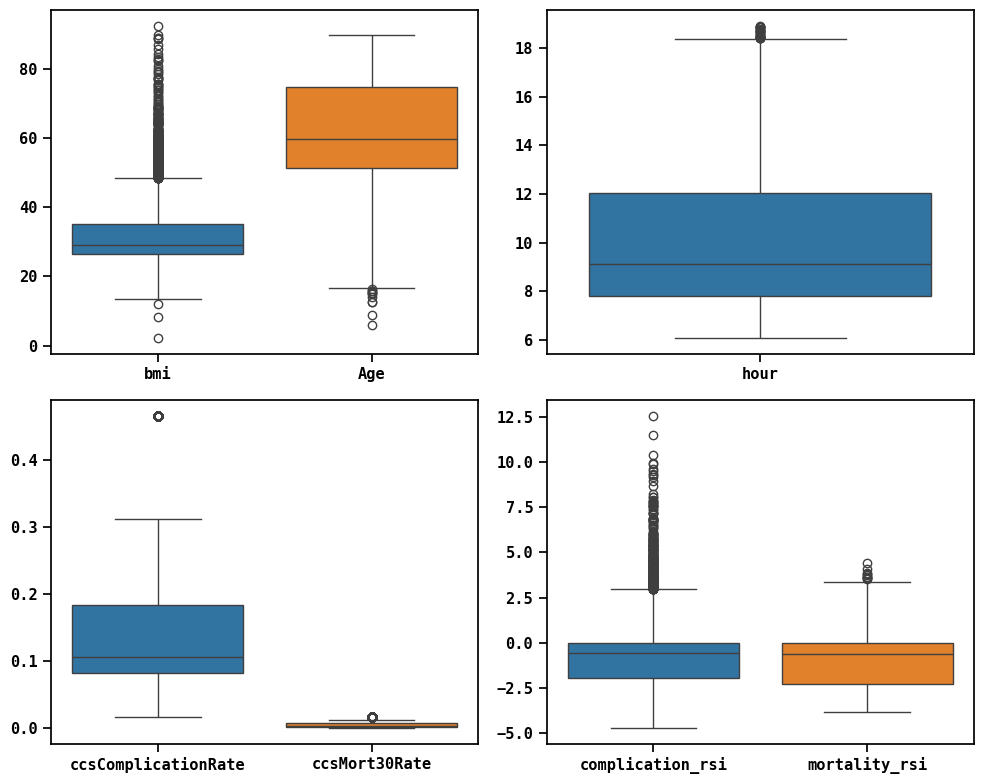

In [242]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
sns.set_context("notebook")

sns.boxplot(data=df[['bmi', 'Age']], ax=axes[0, 0])
sns.boxplot(df[['hour']], ax=axes[0, 1])

sns.boxplot(df[['ccsComplicationRate', 'ccsMort30Rate']], ax=axes[1, 0])
sns.boxplot(df[['complication_rsi', 'mortality_rsi']], ax=axes[1, 1])

plt.tight_layout()
plt.show()

На рисунке приведены боксплоты, показывающие распределение непрерывных числовых признаков.
Точки выше верхней горизонтальной черты и ниже нижней горизонтальной черты на графиках относятся к верхнему и нижнему квартилю, и являются кандидатами для выбросов в данных.

### Диаграммы рассеяния числовых непрерывных признаков

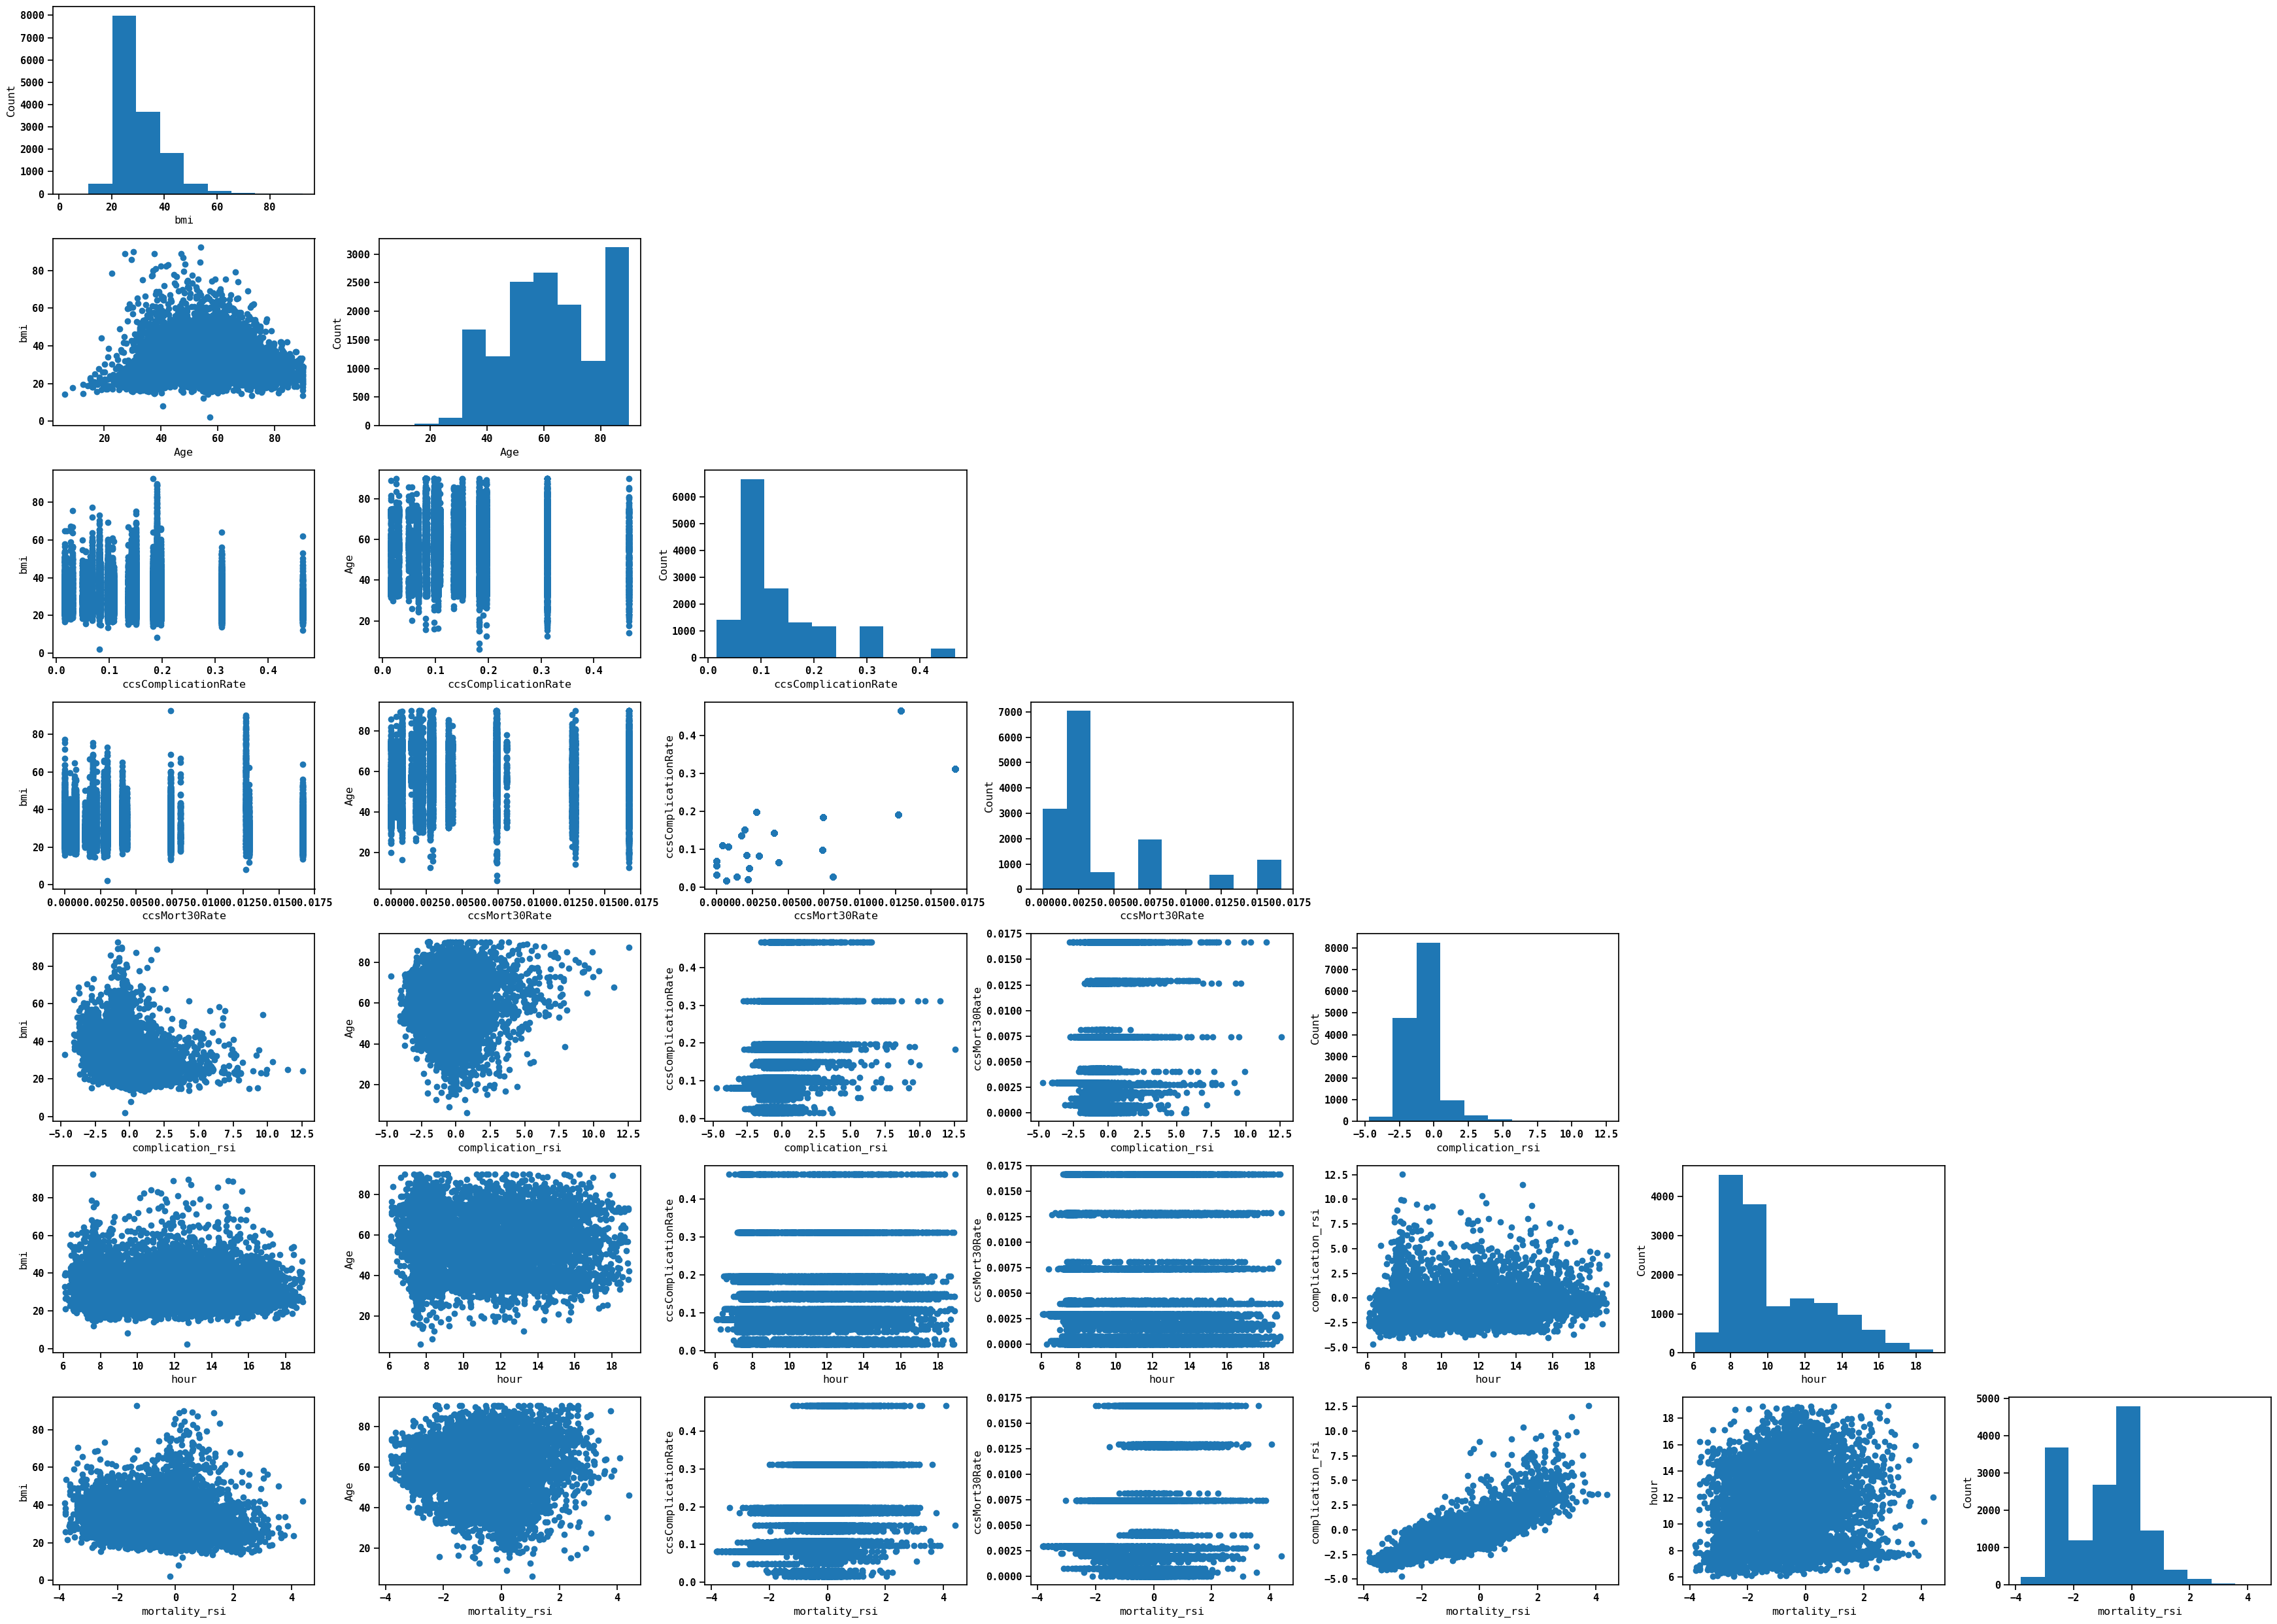

In [243]:
mlxtend.plotting.scatterplotmatrix(df[continuous_cols].values, figsize=(35, 25),
                                   names = df[continuous_cols].columns)
plt.tight_layout()
plt.show()

На рисунке показан набор взаимных диаграмм рассеивания непрерывных признаков. Точки, выходящие за плотные скопления точек (“облака”) на графиках также являются кандидатами для выбросов (наиболее наглядно показано на графиках “Age-bmi”, “hour-complication_rsi”).
Кроме того, на рисунке приведены графики, показывающие распределения указанных признаков по числу встречающихся значений, из которых очевидно, что признаки не принадлежат нормальному распределению.

### Представленность в данных бинарных и категориальных признаков

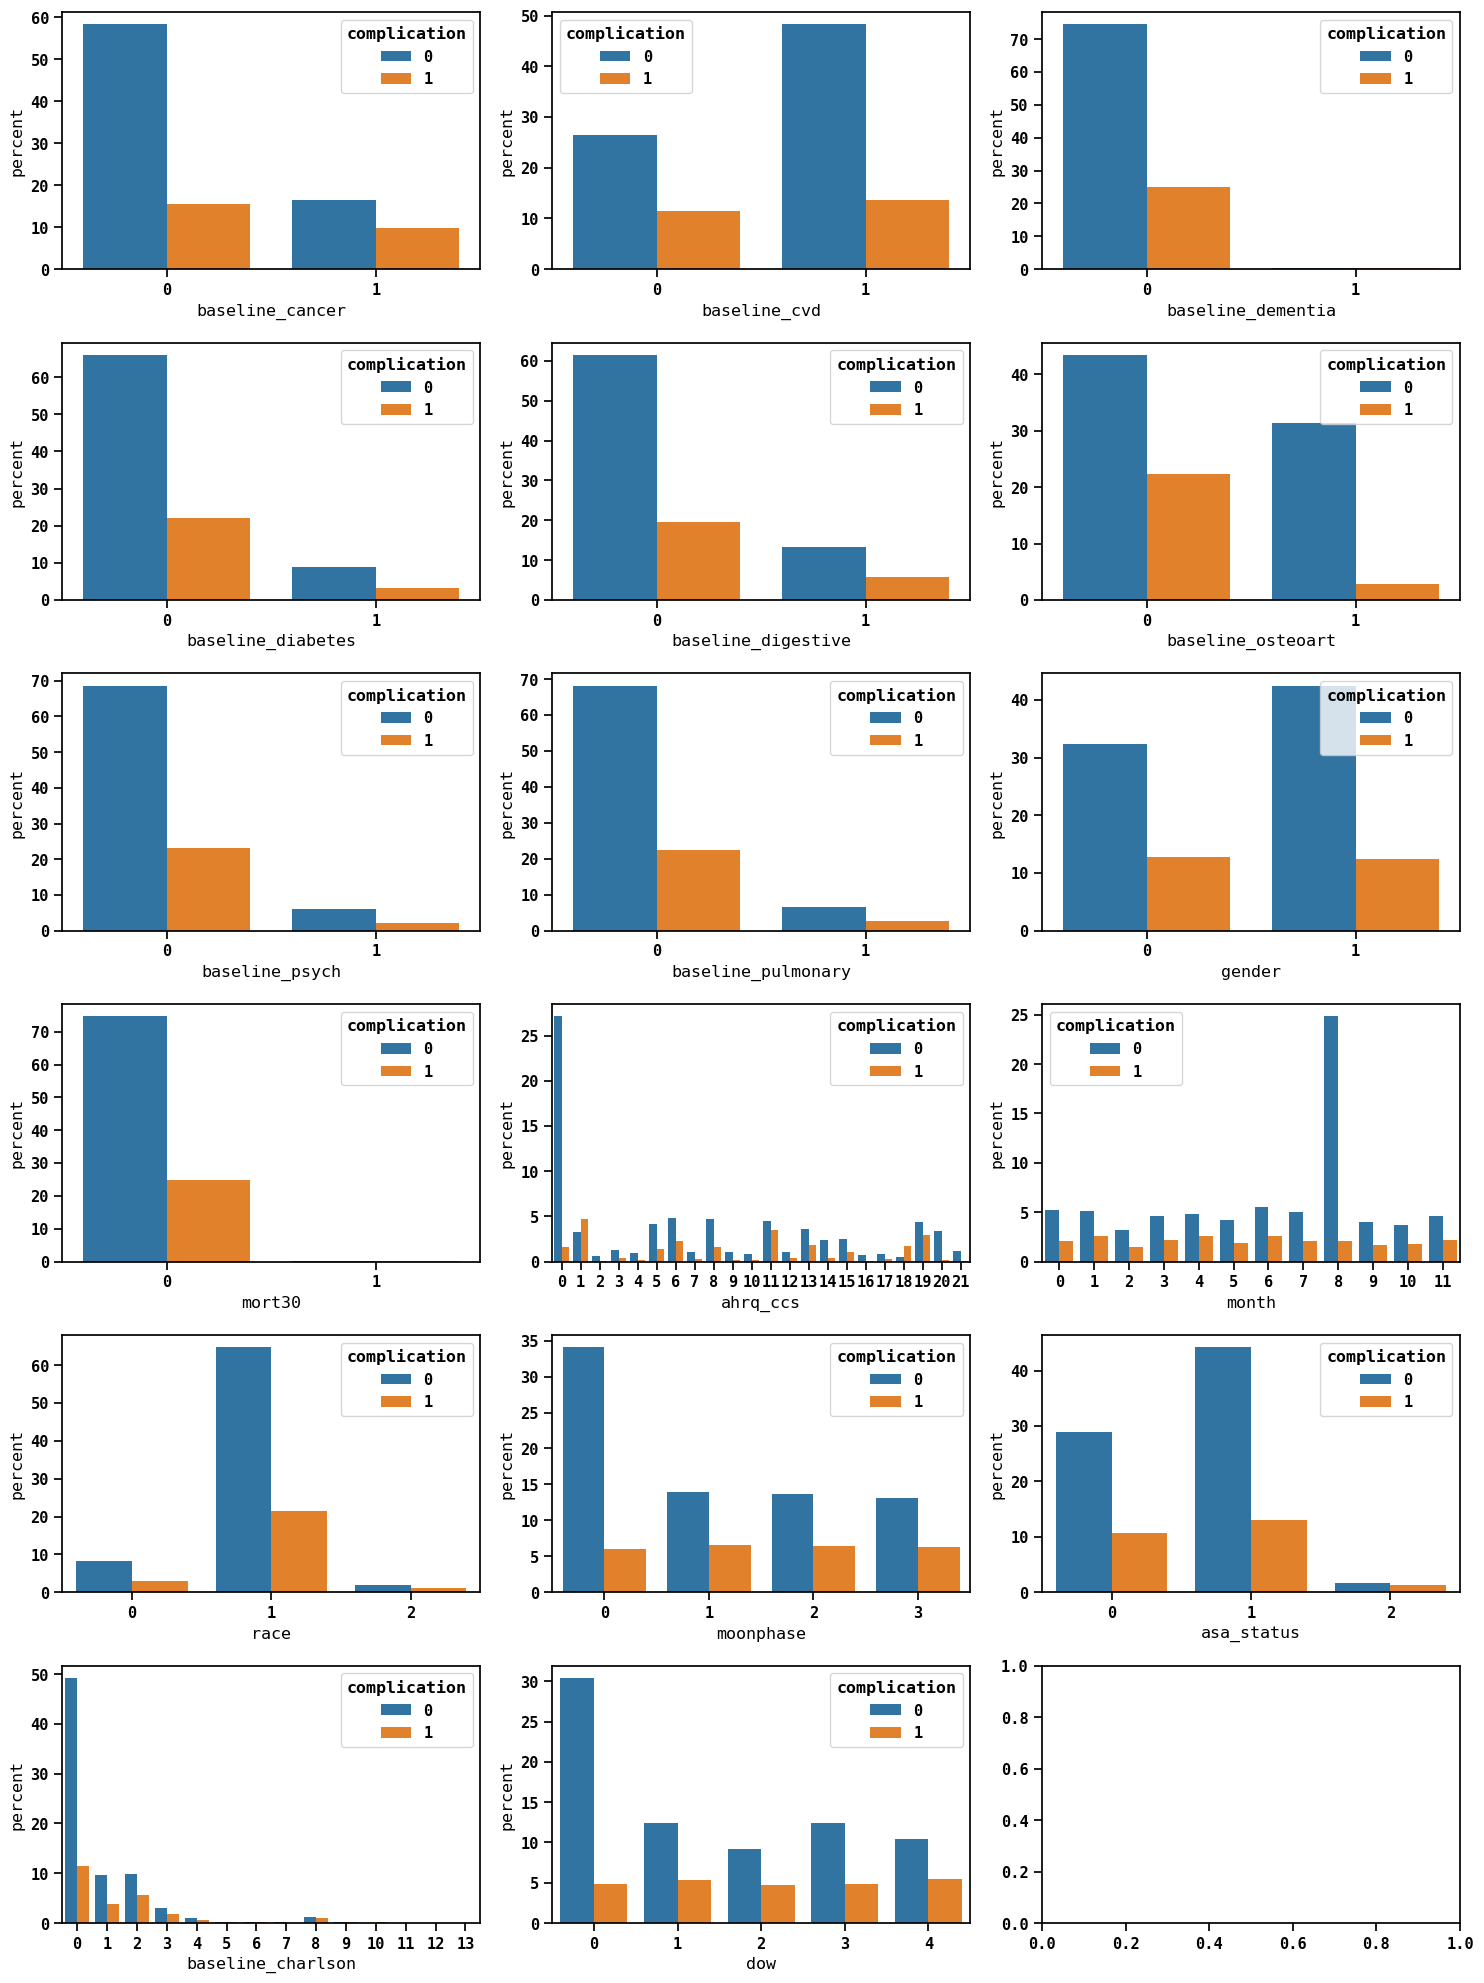

In [244]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 20))
sns.set_context("notebook")

sns.countplot(data=df, x='baseline_cancer', hue='complication', stat='percent', ax=axes[0, 0])
sns.countplot(data=df, x='baseline_cvd', hue='complication', stat='percent', ax=axes[0, 1])
sns.countplot(data=df, x='baseline_dementia', hue='complication', stat='percent', ax=axes[0, 2])

sns.countplot(data=df, x='baseline_diabetes', hue='complication', stat='percent', ax=axes[1, 0])
sns.countplot(data=df, x='baseline_digestive', hue='complication', stat='percent', ax=axes[1, 1])
sns.countplot(data=df, x='baseline_osteoart', hue='complication', stat='percent', ax=axes[1, 2])

sns.countplot(data=df, x='baseline_psych', hue='complication', stat='percent', ax=axes[2, 0])
sns.countplot(data=df, x='baseline_pulmonary', hue='complication', stat='percent', ax=axes[2, 1])
sns.countplot(data=df, x='gender', hue='complication', stat='percent', ax=axes[2, 2])

sns.countplot(data=df, x='mort30', hue='complication', stat='percent', ax=axes[3, 0])
sns.countplot(data=df, x='ahrq_ccs', hue='complication', stat='percent', ax=axes[3, 1])
sns.countplot(data=df, x='month', hue='complication', stat='percent', ax=axes[3, 2])

sns.countplot(data=df, x='race', hue='complication', stat='percent', ax=axes[4, 0])
sns.countplot(data=df, x='moonphase', hue='complication', stat='percent', ax=axes[4, 1])
sns.countplot(data=df, x='asa_status', hue='complication', stat='percent', ax=axes[4, 2])

sns.countplot(data=df, x='baseline_charlson', hue='complication', stat='percent', ax=axes[5, 0])
sns.countplot(data=df, x='dow', hue='complication', stat='percent', ax=axes[5, 1])

plt.tight_layout()
plt.show()

На рисунке показана представленность в датафрейме различных значений бинарных и категориальных признаков (в процентах). Кроме того, в разрезе каждого признака показано распределение целевого признака.
Легко видеть, что количество наблюдений в восьмом месяце превышает значения по остальным месяцам примерно в 5 раз.
Кроме того, заметен дисбаланс признаков “baseline_dementia”, “mort30” и “baseline_charlson”.

### Матрица корреляции данных

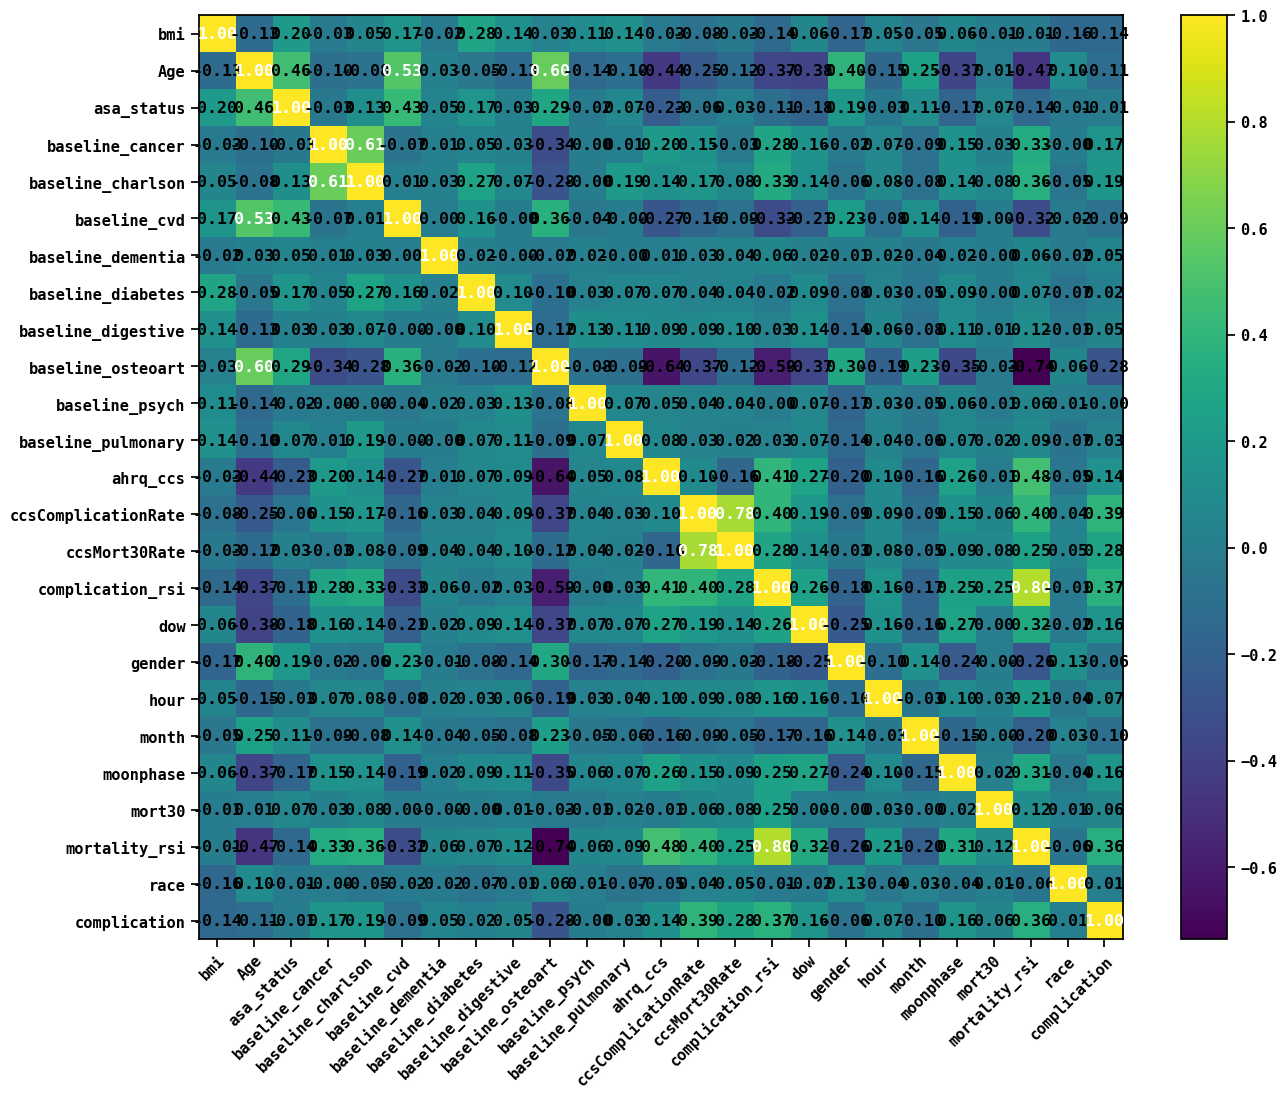

In [245]:
plt.rcParams["figure.figsize"] = (15, 12)
mlxtend.plotting.heatmap(np.corrcoef(df.values.T), row_names = df.columns,
                         column_names=df.columns)
plt.show()

Наибольшие значения корреляции наблюдаются между следующими признаками: “mortality_rsi” и “complication_rsi”, “ccsMort30rate” и “ccsComplicationRate”.
Значительная отрицательная корреляция есть между признаком “baseline_osteoart” и признаками “mortality_rsi” и “ahrq_ccs”.
Наибольшая корреляция с целевым признаком у признаков “ccsComplicationRate”, “complication_rsi” и “mortality_rsi”.

### Графики оценки плотности возраста по признакам

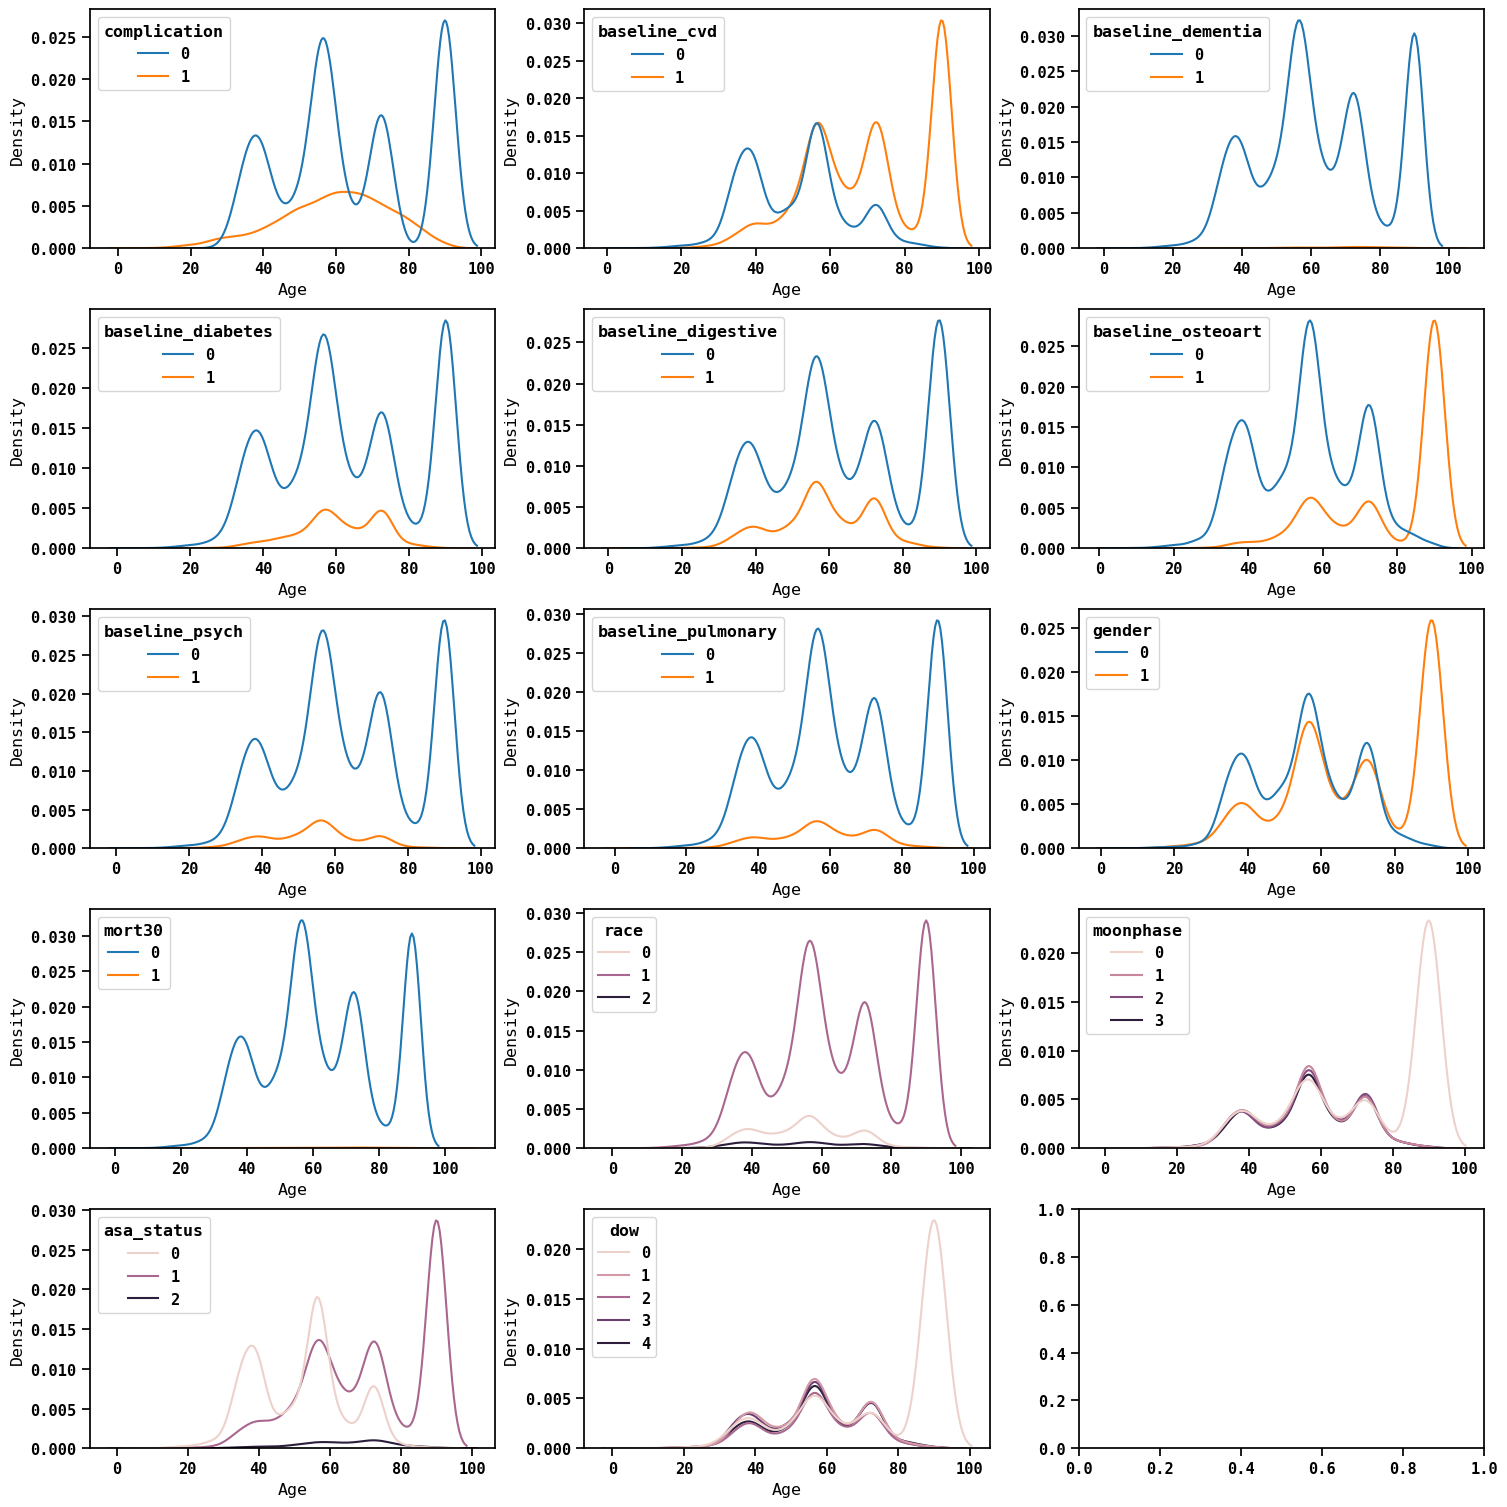

In [246]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
sns.set_context("notebook", rc={'font.size': 4})

sns.kdeplot(data=df, x='Age', hue='complication', ax=axes[0, 0])
sns.kdeplot(data=df, x='Age', hue='baseline_cvd', ax=axes[0, 1])
sns.kdeplot(data=df, x='Age', hue='baseline_dementia', ax=axes[0, 2])

sns.kdeplot(data=df, x='Age', hue='baseline_diabetes', ax=axes[1, 0])
sns.kdeplot(data=df, x='Age', hue='baseline_digestive', ax=axes[1, 1])
sns.kdeplot(data=df, x='Age', hue='baseline_osteoart', ax=axes[1, 2])

sns.kdeplot(data=df, x='Age', hue='baseline_psych', ax=axes[2, 0])
sns.kdeplot(data=df, x='Age', hue='baseline_pulmonary', ax=axes[2, 1])
sns.kdeplot(data=df, x='Age', hue='gender', ax=axes[2, 2])

sns.kdeplot(data=df, x='Age', hue='mort30', ax=axes[3, 0])
sns.kdeplot(data=df, x='Age', hue='race', ax=axes[3, 1])
sns.kdeplot(data=df, x='Age', hue='moonphase', ax=axes[3, 2])

sns.kdeplot(data=df, x='Age', hue='asa_status', ax=axes[4, 0])
sns.kdeplot(data=df, x='Age', hue='dow', ax=axes[4, 1])

plt.tight_layout()
plt.show()

На рисунке приведены графики оценки плотности распределения признака “Age” в разрезе дискретных признаков.
Необходимо отметить, что графики в основном имеют отчётливый “четырёхпиковый” характер, что может свидетельствовать о характере сбора исходной информации. Из данной тенденции выделяется только график “Age-complication” при значении “complication=1”.
Также на графиках “Age-baseline_dementia” и “Age-baseline_mort30” наблюдается недостаток данных со значением “1” зависимых признаков, как уже отмечалось выше.

### Тест на принадлежность числовых непрерывных данных нормальному распределению

In [247]:
for col in continuous_cols:
    stat, p = shapiro(df[col].values)
    print(f'Признак {col}, статистика и p-value согласно тесту Шапиро-Уилка:')
    print(f'stat={stat:.3f}, p={p:.3f}')
    if p > 0.01:
        print('Признак принадлежит нормальному распределению\n')
    else:
        print('Признак не принадлежит нормальному распределению\n')

Признак bmi, статистика и p-value согласно тесту Шапиро-Уилка:
stat=0.890, p=0.000
Признак не принадлежит нормальному распределению

Признак Age, статистика и p-value согласно тесту Шапиро-Уилка:
stat=0.940, p=0.000
Признак не принадлежит нормальному распределению

Признак ccsComplicationRate, статистика и p-value согласно тесту Шапиро-Уилка:
stat=0.822, p=0.000
Признак не принадлежит нормальному распределению

Признак ccsMort30Rate, статистика и p-value согласно тесту Шапиро-Уилка:
stat=0.744, p=0.000
Признак не принадлежит нормальному распределению

Признак complication_rsi, статистика и p-value согласно тесту Шапиро-Уилка:
stat=0.874, p=0.000
Признак не принадлежит нормальному распределению

Признак hour, статистика и p-value согласно тесту Шапиро-Уилка:
stat=0.889, p=0.000
Признак не принадлежит нормальному распределению

Признак mortality_rsi, статистика и p-value согласно тесту Шапиро-Уилка:
stat=0.950, p=0.000
Признак не принадлежит нормальному распределению



### z-score

In [248]:
z = stats.zscore(df[continuous_cols])

In [249]:
z_mask = (np.abs(z) < 3).all(axis = 1)
df_z = df[z_mask]
print(f'По методу z-score останется {df_z.shape[0]/df.shape[0]*100:.2f} % строк')

По методу z-score останется 94.64 % строк


In [250]:
df_z.shape

(13850, 25)

### IQR

In [251]:
Q1 = df[continuous_cols].quantile(0.25)
Q3 = df[continuous_cols].quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

In [252]:
mask_out = ((df[continuous_cols] < lower) | (df[continuous_cols] > upper)).any(axis = 1)
print(f'По методу IQR останется {100-(df[mask_out].shape[0]/df.shape[0]*100):.2f} % строк')

По методу IQR останется 84.94 % строк


Легко видеть, что исключение выбросов методом z-score приводит к незначительному уменьшению исходного датафрейма (около 5 %), в отличие метода IQR (около 15 %). Принимая во внимание небольшой объём исходной информации, целесообразно провести исключение выбросов методом z-score.
Таким образом размер полученной таблицы составит 13850 строк и 25 столбцов.

In [253]:
df = df_z
df

,bmi,Age,asa_status,baseline_cancer,baseline_charlson,baseline_cvd,baseline_dementia,baseline_diabetes,baseline_digestive,baseline_osteoart,baseline_psych,baseline_pulmonary,ahrq_ccs,ccsComplicationRate,ccsMort30Rate,complication_rsi,dow,gender,hour,month,moonphase,mort30,mortality_rsi,race,complication
0,19.31,59.2,1,1,0,0,0,0,0,0,0,0,19,0.183370,0.007424,-0.57,3,0,7.63,6,1,0,-0.43,1,0
1,18.73,59.1,0,0,0,0,0,0,0,0,0,0,1,0.312029,0.016673,0.21,0,0,12.93,0,1,0,-0.41,1,0
2,21.85,59.0,0,0,0,0,0,0,0,0,0,0,6,0.150706,0.001962,0.00,2,0,7.68,5,3,0,0.08,1,0
3,18.49,59.0,1,0,1,0,0,1,1,0,0,0,7,0.056166,0.000000,-0.65,2,1,7.58,4,3,0,-0.32,1,0
4,19.70,59.0,1,0,0,0,0,0,0,0,0,0,11,0.197305,0.002764,0.00,0,0,7.88,11,0,0,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14627,20.00,15.3,0,0,0,0,0,0,0,0,0,0,1,0.312029,0.016673,-0.23,1,0,9.22,1,2,0,0.28,1,1
14628,22.91,15.1,0,0,2,0,0,0,0,0,0,0,19,0.183370,0.007424,2.26,1,0,8.25,5,0,0,2.38,1,1
14629,22.27,15.0,0,0,0,0,0,0,0,0,0,0,19,0.183370,0.007424,0.00,1,0,7.80,10,2,0,-0.93,1,1
14631,19.65,12.6,0,0,0,0,0,0,0,0,0,0,1,0.312029,0.016673,-1.42,4,0,8.40,6,1,0,-0.77,1,1


## Решение задачи классификации

In [ ]:
# устанавливаем значение случайного числа в переменной и размер тестовой выборки
RANDOM_STATE = 42
TEST_SIZE = 0.15

In [ ]:
# выделяем целевой признак для классификации и определяем датасет для классификации
y = df[target]
df_class = df.drop(target, axis=1)

In [ ]:
# разделяем данные на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(
    df_class,
    y,
    test_size = TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
    )

In [66]:
print(f'Размер тренировочной выборки: {X_train.shape}\n \
Размер тестовой выборки {X_test.shape}')

Размер тренировочной выборки: (11772, 24)
 Размер тестовой выборки (2078, 24)


In [ ]:
# определяем обработку признаков по выделенной природе признаков
preprocessor = ColumnTransformer(
    [
        ('binary', OneHotEncoder(drop='if_binary'), binary_cols),
        ('category', OneHotEncoder(drop='first'), category_cols),
        ('numeric', StandardScaler(), continuous_cols),
        ('ordinal', OrdinalEncoder(), ordinal_cols)
    ],
    sparse_threshold=0,
    remainder='drop',
    verbose_feature_names_out=False
)

In [68]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_train_transformed = pd.DataFrame(
    X_train_transformed,
    columns=preprocessor.get_feature_names_out()
    )

In [69]:
X_test_transformed = preprocessor.fit_transform(X_test)
X_test_transformed = pd.DataFrame(
    X_test_transformed,
    columns=preprocessor.get_feature_names_out()
    )

In [70]:
X_train_transformed.describe()

,baseline_cancer_1,baseline_cvd_1,baseline_dementia_1,baseline_diabetes_1,baseline_digestive_1,baseline_osteoart_1,baseline_psych_1,baseline_pulmonary_1,gender_1,mort30_1,ahrq_ccs_1,ahrq_ccs_2,ahrq_ccs_3,ahrq_ccs_4,ahrq_ccs_5,ahrq_ccs_6,ahrq_ccs_7,ahrq_ccs_8,ahrq_ccs_9,ahrq_ccs_10,ahrq_ccs_11,ahrq_ccs_12,ahrq_ccs_13,ahrq_ccs_14,ahrq_ccs_15,ahrq_ccs_16,ahrq_ccs_17,ahrq_ccs_19,ahrq_ccs_20,ahrq_ccs_21,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,race_1,race_2,moonphase_1,moonphase_2,moonphase_3,bmi,Age,ccsComplicationRate,ccsMort30Rate,complication_rsi,hour,mortality_rsi,asa_status,baseline_charlson,dow
count,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.000000,11772.00000,1.177200e+04,1.177200e+04,1.177200e+04,1.177200e+04,1.177200e+04,1.177200e+04,1.177200e+04,11772.000000,11772.000000,11772.000000
mean,0.261468,0.627336,0.004502,0.117567,0.186035,0.352277,0.080360,0.090979,0.555556,0.001444,0.078576,0.006626,0.012147,0.011638,0.054451,0.071271,0.014781,0.064645,0.011978,0.010109,0.081464,0.016395,0.056405,0.028118,0.036952,0.008665,0.010958,0.074159,0.037887,0.013507,0.076283,0.045192,0.066259,0.074499,0.059123,0.082144,0.069997,0.278372,0.055810,0.052752,0.066684,0.861961,0.028882,0.203024,0.193680,0.19300,2.227236e-16,-3.434411e-16,3.174868e-16,1.315820e-16,5.190849e-17,-2.756884e-16,9.657394e-18,0.621135,0.954213,1.580785
std,0.439453,0.483534,0.066950,0.322109,0.389151,0.477700,0.271862,0.287591,0.496925,0.037976,0.269088,0.081133,0.109549,0.107254,0.226916,0.257288,0.120680,0.245909,0.108789,0.100037,0.273559,0.126994,0.230712,0.165316,0.188652,0.092684,0.104111,0.262041,0.190930,0.115435,0.265461,0.207734,0.248745,0.262592,0.235865,0.274596,0.255152,0.448217,0.229565,0.223548,0.249484,0.344956,0.167482,0.402267,0.395198,0.39467,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,0.531424,1.735170,1.498057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-3.238754e+00,-2.820448e+00,-1.485761e+00,-9.513992e-01,-2.963412e+00,-1.549267e+00,-2.566095e+00,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,-6.158375e-01,-6.264811e-01,-5.805014e-01,-4.994832e-01,-1.058147e+00,-8.829037e-01,-1.181248e+00,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,-2.824760e-01,-1.937706e-01,-3.674583e-0

### Логистическая регрессия

In [71]:
clf = LogisticRegression(random_state=RANDOM_STATE)

In [ ]:
# определяем сетку гиперпараметров для поиска
c_range = [0.01, 0.1, 1, 10, 25, 50]
param_grid = [
    {'C': c_range,
     'penalty': ['l1', 'l2'],
     'solver': ['liblinear', 'saga']
     },
    {'C': c_range,
     'penalty': ['l2'],
     'solver': ['lbfgs', 'newton-cg', 'sag']}
]

In [ ]:
# устанавливаем поиск по сетке
gs = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='f1'
)

In [74]:
gs = gs.fit(X_train_transformed, y_train)

In [75]:
gs.best_score_

0.4266439141901007

In [76]:
gs.best_params_

{'C': 25, 'penalty': 'l2', 'solver': 'saga'}

In [ ]:
clf = gs.best_estimator_

LogisticRegression(C=25, random_state=42, solver='saga')

In [78]:
y_pred = clf.predict(X_test_transformed)

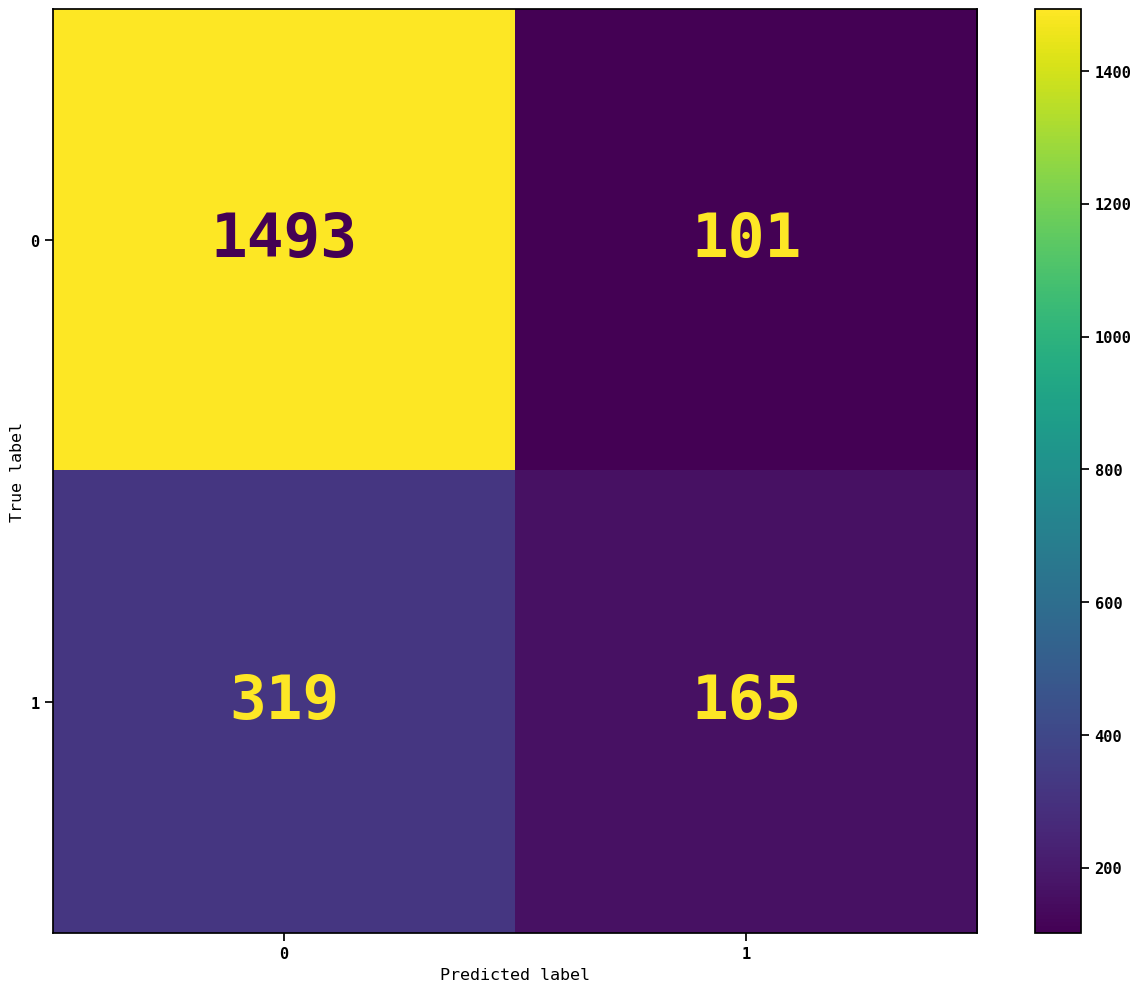

In [79]:
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 44}
plt.rc('font', **font)
confmat = metrics.confusion_matrix(y_test, y_pred)
confmat_display = metrics.ConfusionMatrixDisplay(confmat)
confmat_display.plot()
plt.show()

In [80]:
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)
mcc = metrics.matthews_corrcoef(y_test, y_pred)
error = 1 - metrics.accuracy_score(y_test, y_pred)
print(f'Значения основных метрик на тестовых данных:\n \
Ошибка прогнозирования {error:.3f}\n \
Точность {precision:.3f}\n \
Полнота {recall:.3f}\n \
F1_score {f1_score:.3f}\n \
Коэффициент корреляции {mcc:.3f}')

Значения основных метрик на тестовых данных:
 Ошибка прогнозирования 0.202
 Точность 0.620
 Полнота 0.341
 F1_score 0.440
 Коэффициент корреляции 0.351


Матрица несоответствий показывает большое количество ложноположительных и ложноотрицательных предсказаний на тестовой выборке.
Также очевидны довольно низкие показатели f1, точности, полноты и ошибки.

### Анализ основных комнонент

In [107]:
pca_full = PCA(n_components=None)
X_train_pca_full = pca_full.fit_transform(X_train_transformed)

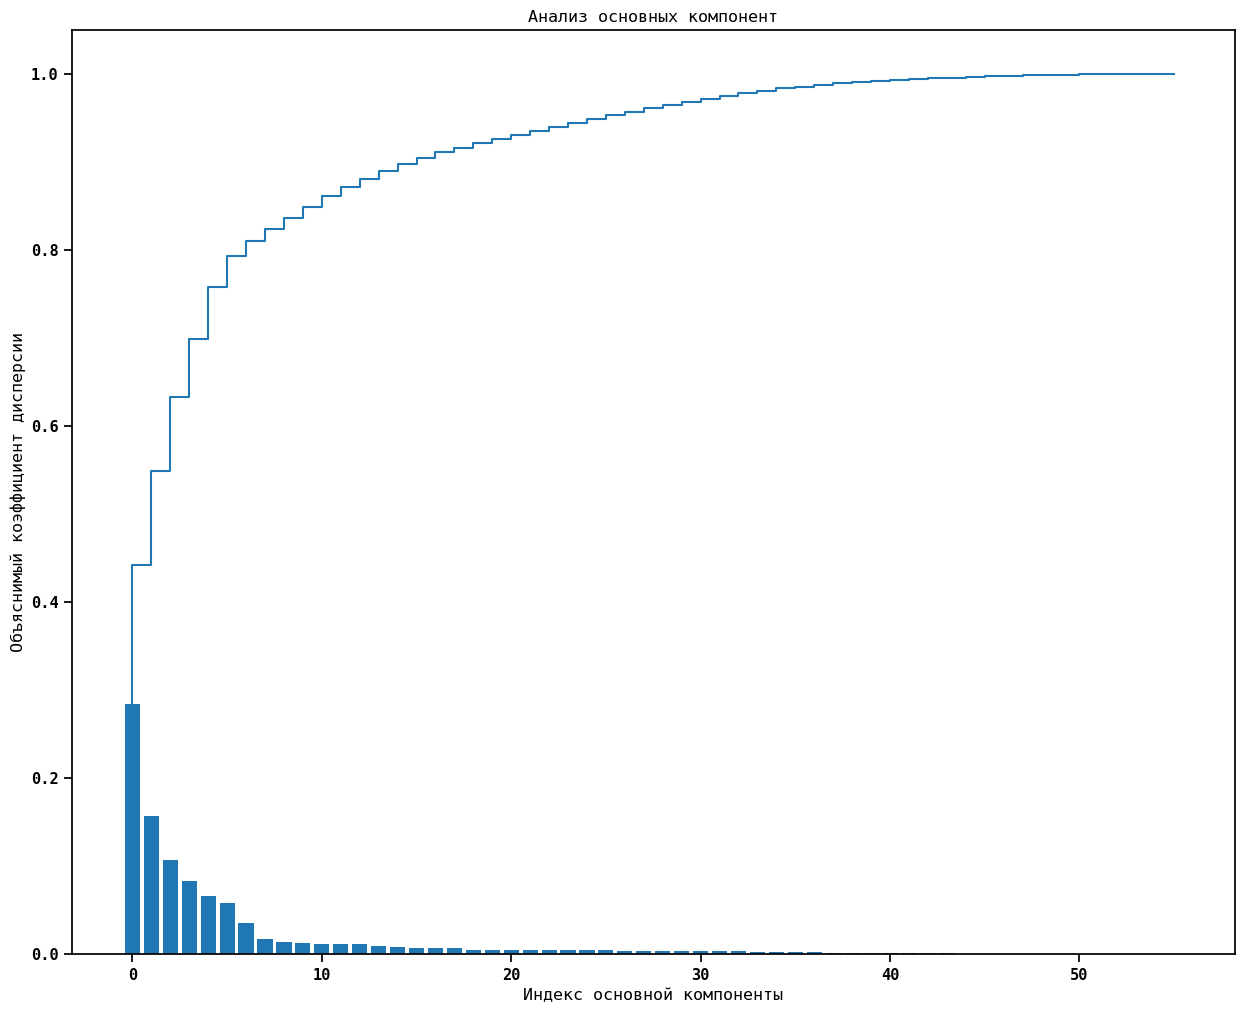

In [108]:
plt.bar(
    range(X_train_pca_full.shape[1]), 
    pca_full.explained_variance_ratio_, 
    label='Индивидуальная объяснимая доля дисперсии'
    )
plt.step(
    range(X_train_pca_full.shape[1]),
    np.cumsum(pca_full.explained_variance_ratio_,),
    label='Кумулятивная обяснимая доля дисперсии'
    )
plt.title('Анализ основных компонент')
plt.ylabel('Объяснимый коэффициент дисперсии')
plt.xlabel('Индекс основной компоненты')
plt.show()

Около 80% дисперсии объясняют 7 компонент, выделяемых PCA.

In [109]:
pca = PCA(n_components=7)
clf_pca = LogisticRegression(random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_transformed)
X_test_pca = pca.transform(X_test_transformed)
clf_pca.fit(X_train_pca, y_train)
y_pred_pca = clf_pca.predict(X_test_pca)

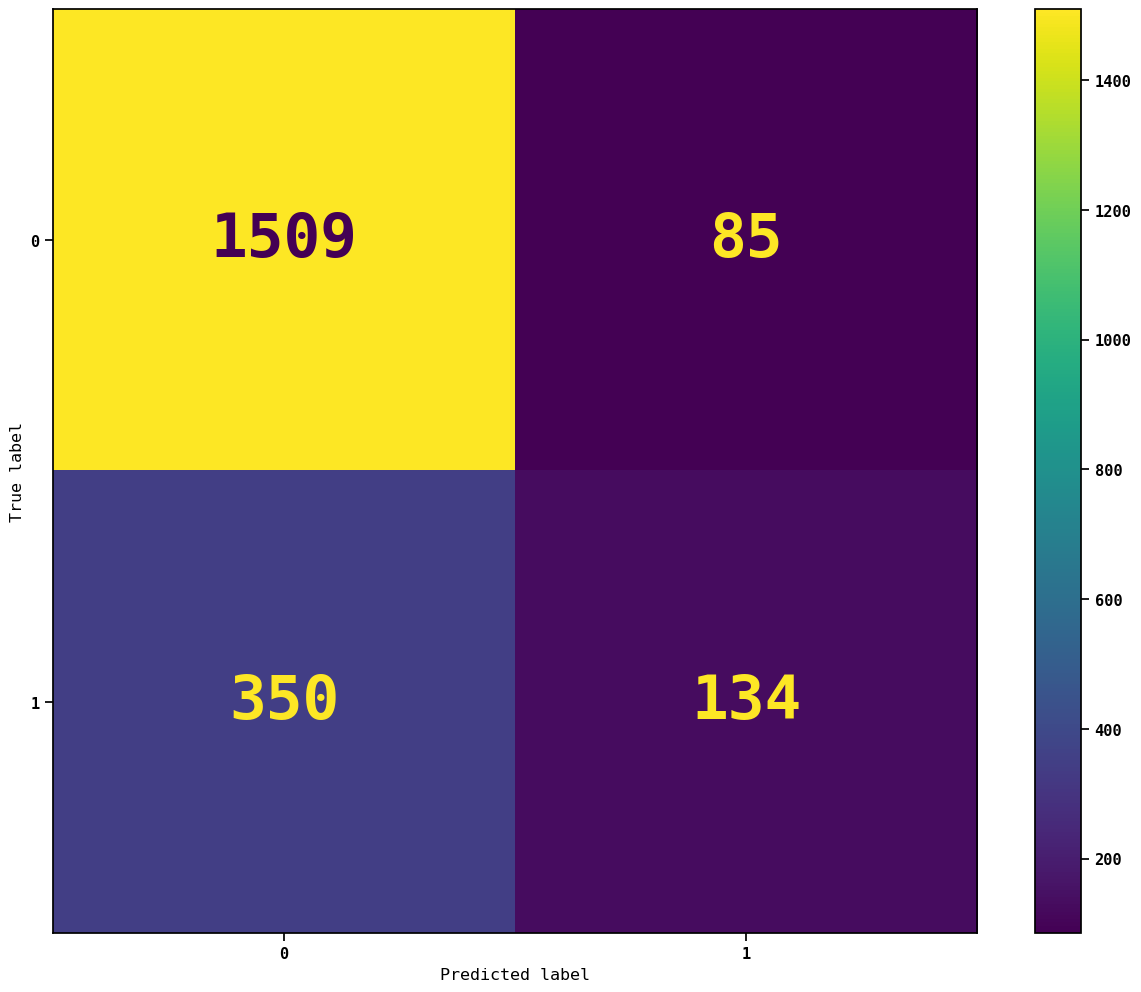

In [110]:
confmat_pca = metrics.confusion_matrix(y_test, y_pred_pca)
confmat_pca_display = metrics.ConfusionMatrixDisplay(confmat_pca)
confmat_pca_display.plot()
plt.show()

In [111]:
precision = metrics.precision_score(y_test, y_pred_pca)
recall = metrics.recall_score(y_test, y_pred_pca)
f1_score = metrics.f1_score(y_test, y_pred_pca)
mcc = metrics.matthews_corrcoef(y_test, y_pred_pca)
error = 1 - metrics.accuracy_score(y_test, y_pred_pca)
print(f'Значения основных метрик на тестовых данных:\n \
Ошибка прогнозирования {error:.3f}\n \
Точность {precision:.3f}\n \
Полнота {recall:.3f}\n \
F1_score {f1_score:.3f}\n \
Коэффициент корреляции {mcc:.3f}')

Значения основных метрик на тестовых данных:
 Ошибка прогнозирования 0.209
 Точность 0.612
 Полнота 0.277
 F1_score 0.381
 Коэффициент корреляции 0.308


PCA, использующий 7 основных компонент, уменьшило показатель recall и, соответственно, f1. Увеличилось количество ложноотрицательных предсказаний.

In [ ]:
def plot_decision_regions(X, y, classifier, resolution=0.02):
    """Функция для визуализации границ классификаторов
    """
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        mask = y==cl
        plt.scatter(x=X[mask.flatten(), 0], 
                    y=X[mask.flatten(), 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

7 компонент на одном графике отобразить довольно трудно, поэтому дополнительно возможно построить график, проецирующий данные на 2 основные компоненты.

In [115]:
pca_c2 = PCA(n_components=2)
clf_pca_c2 = LogisticRegression(random_state=RANDOM_STATE)
X_train_pca_c2 = pca_c2.fit_transform(X_train_transformed)
X_test_pca_c2 = pca_c2.transform(X_test_transformed)
clf_pca_c2.fit(X_train_pca_c2, y_train)
y_pred_pca_c2 = clf_pca_c2.predict(X_test_pca_c2)

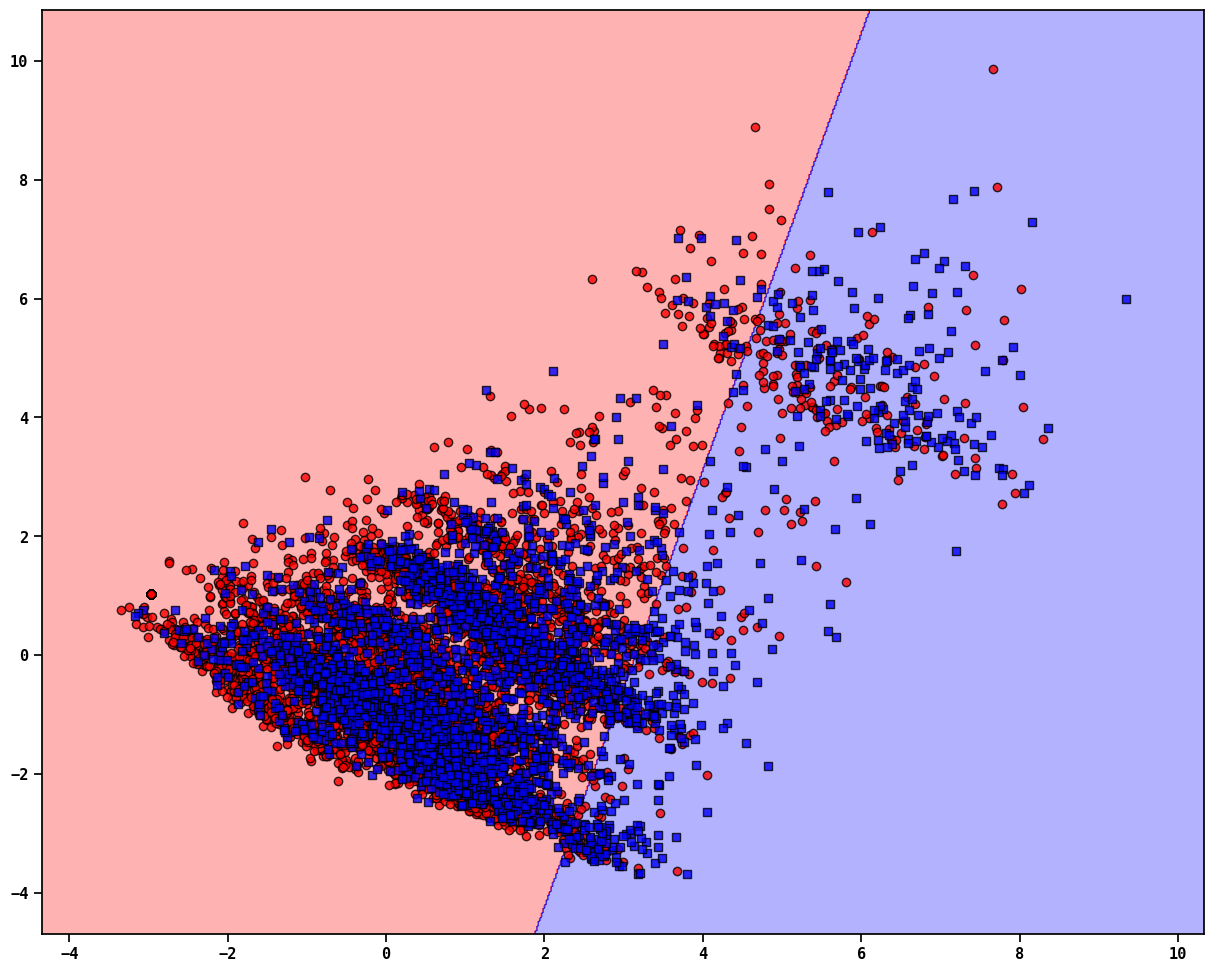

In [183]:
plot_decision_regions(X_train_pca_c2, y_train.values, classifier=clf_pca_c2)

Из графика хорошо видно, что линейную разделяющую границу между классами построить невозможно.

### t-SNE

In [330]:
tsne = TSNE(n_components=2, init='pca', random_state=RANDOM_STATE) 
# число компонентов - 2 для удобства визуализации
X_train_tsne = tsne.fit_transform(X_train)

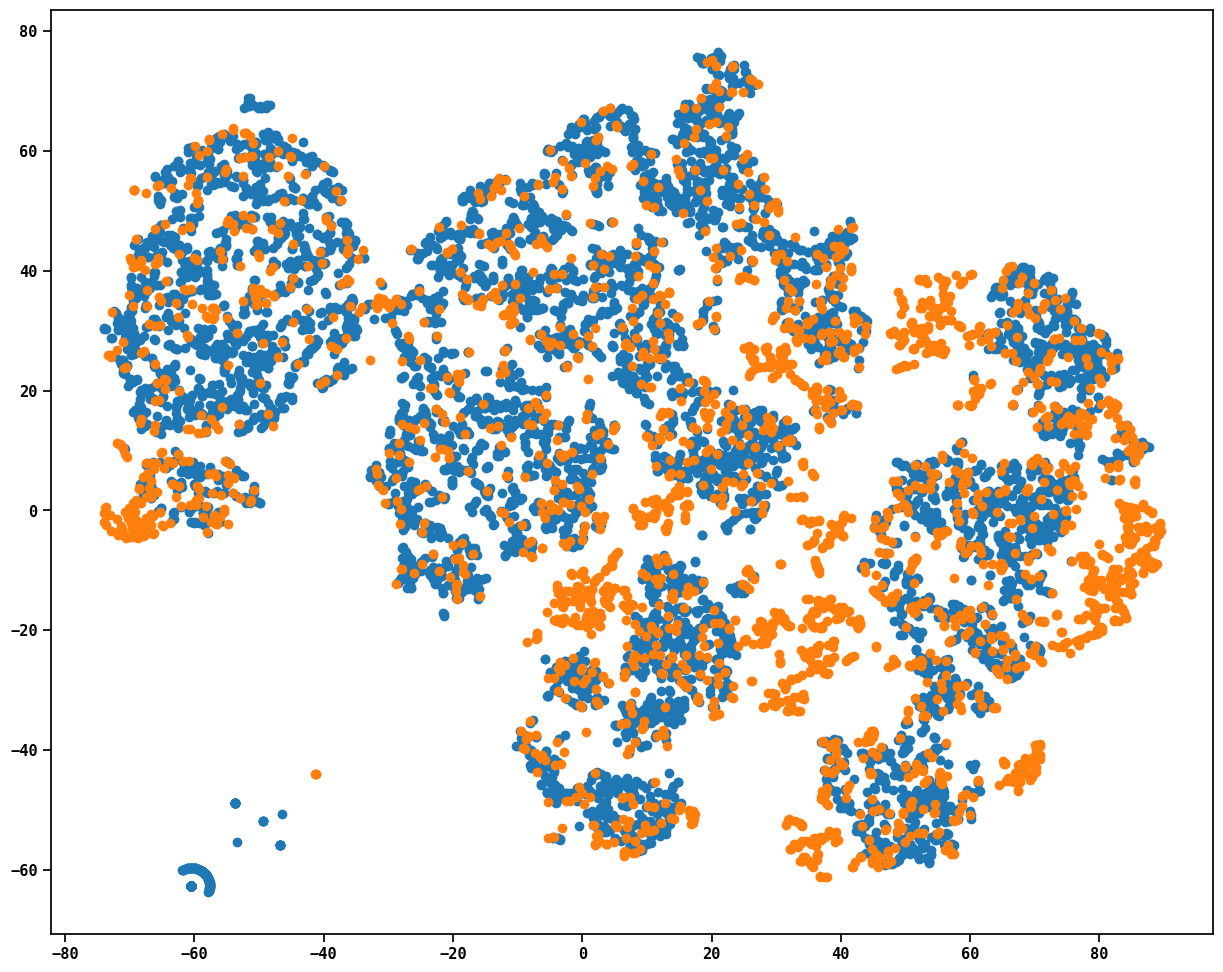

In [335]:
for idx, cl in enumerate(np.unique(y_train.values)):
        mask = y_train.values==cl
        plt.scatter(x=X_train_tsne[mask.flatten(), 0], 
                    y=X_train_tsne[mask.flatten(), 1])
plt.show()

Нелинейная модель t-SNE также не может хорошо разделить данные по двум осям.

### Другие классификаторы и пайплайн

In [371]:
encoders_num = [
    StandardScaler(),
    RobustScaler(),
    MinMaxScaler(),
]

preprocessor = ColumnTransformer(
    [
        ('category', OneHotEncoder(drop='first'), category_cols+binary_cols),
        ('numeric', StandardScaler(), continuous_cols),
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value',
                                   unknown_value=np.nan), ordinal_cols),
    ],
    sparse_threshold=0,
    remainder='drop',
    verbose_feature_names_out=False,
)

param_space = [
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__C': np.logspace(-1, 3, 5, base=10),
        'models__kernel': ['rbf'],
        'preprocessor__numeric': encoders_num,
    },
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__C': np.logspace(-1, 3, 5, base=10),
        'models__kernel': ['poly'],
        'models__degree': np.arange(1, 4),
        'preprocessor__numeric': encoders_num,
    },
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': np.arange(25, 250, step=50),
        'models__max_features': ['sqrt', 'log2', None],
        'models__max_depth': np.arange(2, 6),
        'models__min_samples_leaf': np.arange(2, 4),
        'preprocessor__numeric': ['passthrough'],
    },
]

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('drop_nan', SimpleImputer(strategy='most_frequent')),
    ('models', SVC(random_state=RANDOM_STATE)),
])

search = GridSearchCV(
    pipeline,
    param_grid=param_space,
    cv=3,
    scoring='f1',
)
search.fit(X_train, y_train)
search_df = pd.DataFrame(search.cv_results_)

In [372]:
search_df.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__C,param_models__kernel,param_preprocessor__numeric,param_models__degree,param_models__max_depth,param_models__max_features,param_models__min_samples_leaf,param_models__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
179,3.104260,0.036109,0.052527,0.000647,RandomForestClassifier(random_state=42),NaN,NaN,passthrough,NaN,5.0,None,3.0,225.0,{'models': RandomForestClassifier(random_state...,0.627151,0.489796,0.628342,0.581763,0.065032,1
174,3.081764,0.014066,0.052453,0.000490,RandomForestClassifier(random_state=42),NaN,NaN,passthrough,NaN,5.0,None,2.0,225.0,{'models': RandomForestClassifier(random_state...,0.627151,0.489796,0.628342,0.581763,0.065032,1
178,2.413442,0.012534,0.043907,0.000936,RandomForestClassifier(random_state=42),NaN,NaN,passthrough,NaN,5.0,None,3.0,175.0,{'models': RandomForestClassifier(random_state...,0.628681,0.488654,0.627346,0.581560,0.065697,3
173,2.410725,0.017520,0.044053,0.000381,RandomForestClassifier(random_state=42),NaN,NaN,passthrough,NaN,5.0,None,2.0,175.0,{'models': RandomForestClassifier(random_state...,0.629559,0.488654,0.626425,0.581546,0.065697,4
170,0.388062,0.001972,0.020809,0.000336,RandomForestClassifier(random_state=42),NaN,NaN,passthrough,NaN,5.0,None,2.0,25.0,{'models': RandomForestClassifier(random_state...,0.626476,0.487879,0.627737,0.580697,0.065635,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.097358,0.000188,0.019279,0.000358,RandomForestClassifier(random_state=42),NaN,NaN,passthrough,NaN,2.0,log2,2.0,25.0,{'models': RandomForestClassifier(random_state...,0.000000,0.000000,0.000000,0.000000,0.000000,175
74,0.488661,0.002180,0.042097,0.000656,RandomForestClassifier(random_state=42),NaN,NaN,passthrough,NaN,2.0,log2,2.0,225.0,{'models': RandomForestClassifier(random_state...,0.000000,0.000000,0.000000,0.000000,0.000000,175
76,0.195858,0.001723,0.025705,0.000522,RandomForestClassifier(random_state=42),NaN,NaN,passthrough,NaN,2.0,log2,3.0,75.0,{'models': RandomForestClassifier(random_state...,0.000000,0.000000,0.000000,0.000000,0.000000,175
79,0.490188,0.002821,0.041162,0.000647,RandomForestClassifier(random_state=42),NaN,NaN,passthrough,NaN,2.0,log2,3.0,225.0,{'models': RandomForestClassifier(random_state...,0.000000,0.000000,0.000000,0.000000,0.000000,175


In [373]:
search_df.to_excel('search_classifier.xlsx')

Полный пайплайн с поиском по сетке показывает превосходство случайного леса над классификаторами на основе метода SVM.

In [ ]:
search_model = search.best_estimator_
y_pred_search = search_model.predict(X_test)
precision = metrics.precision_score(y_test, y_pred_search)
recall = metrics.recall_score(y_test, y_pred_search)
f1_score = metrics.f1_score(y_test, y_pred_search)
mcc = metrics.matthews_corrcoef(y_test, y_pred_search)
error = 1 - metrics.accuracy_score(y_test, y_pred_search)
print(f'Значения основных метрик на тестовых данных:\n \
Ошибка прогнозирования {error:.3f}\n \
Точность {precision:.3f}\n \
Полнота {recall:.3f}\n \
F1_score {f1_score:.3f}\n \
Коэффициент корреляции {mcc:.3f}')

Значения основных метрик на тестовых данных:
 Ошибка прогнозирования 0.162
 Точность 0.821
 Полнота 0.388
 F1_score 0.527
 Коэффициент корреляции 0.490


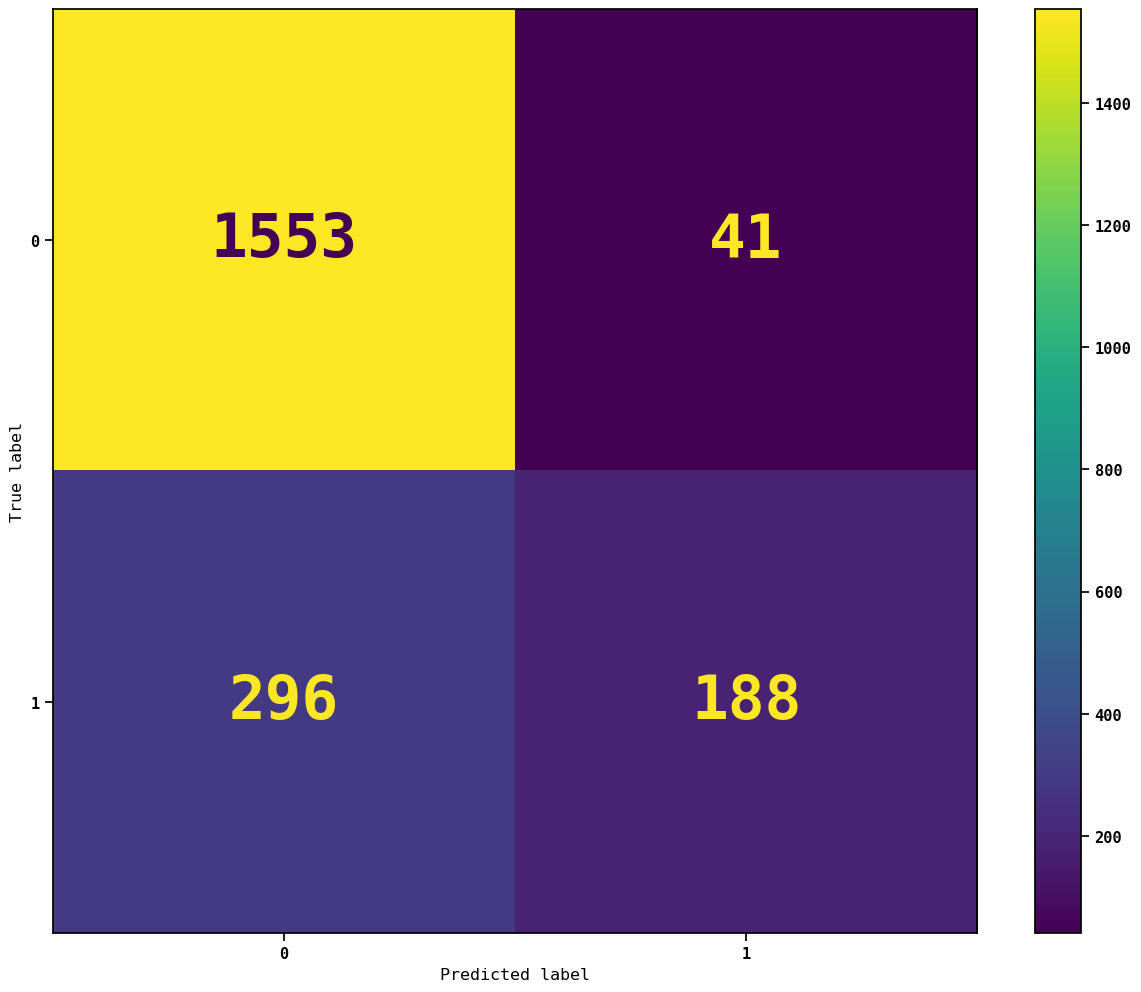

In [ ]:
confmat_search = metrics.confusion_matrix(y_test, y_pred_search)
confmat_search_display = metrics.ConfusionMatrixDisplay(confmat_search)
confmat_search_display.plot()
plt.show()

Лучшая модель показывает и лучшие метрики. Уменьшились ложные прогнозы модели.
Возможно, стоит попробовать в качестве метрики использовать recall.
Или использовать ансамль моделей на основе методов SVM, логистической регрессии и случайного леса с последующим их голосованием.

 1) Age                            0.513167
 2) ccsComplicationRate            0.311498
 3) complication_rsi               0.159703
 4) bmi                            0.008487
 5) mortality_rsi                  0.002089
 6) hour                           0.001674
 7) baseline_charlson              0.000765
 8) month_8                        0.000532
 9) dow                            0.000363
10) gender_1                       0.000301
11) ccsMort30Rate                  0.000282
12) ahrq_ccs_1                     0.000158
13) baseline_digestive_1           0.000148
14) baseline_diabetes_1            0.000078
15) month_4                        0.000065
16) moonphase_2                    0.000062
17) baseline_cancer_1              0.000061
18) race_1                         0.000060
19) month_7                        0.000057
20) asa_status                     0.000053
21) month_3                        0.000045
22) month_6                        0.000044
23) month_11                    

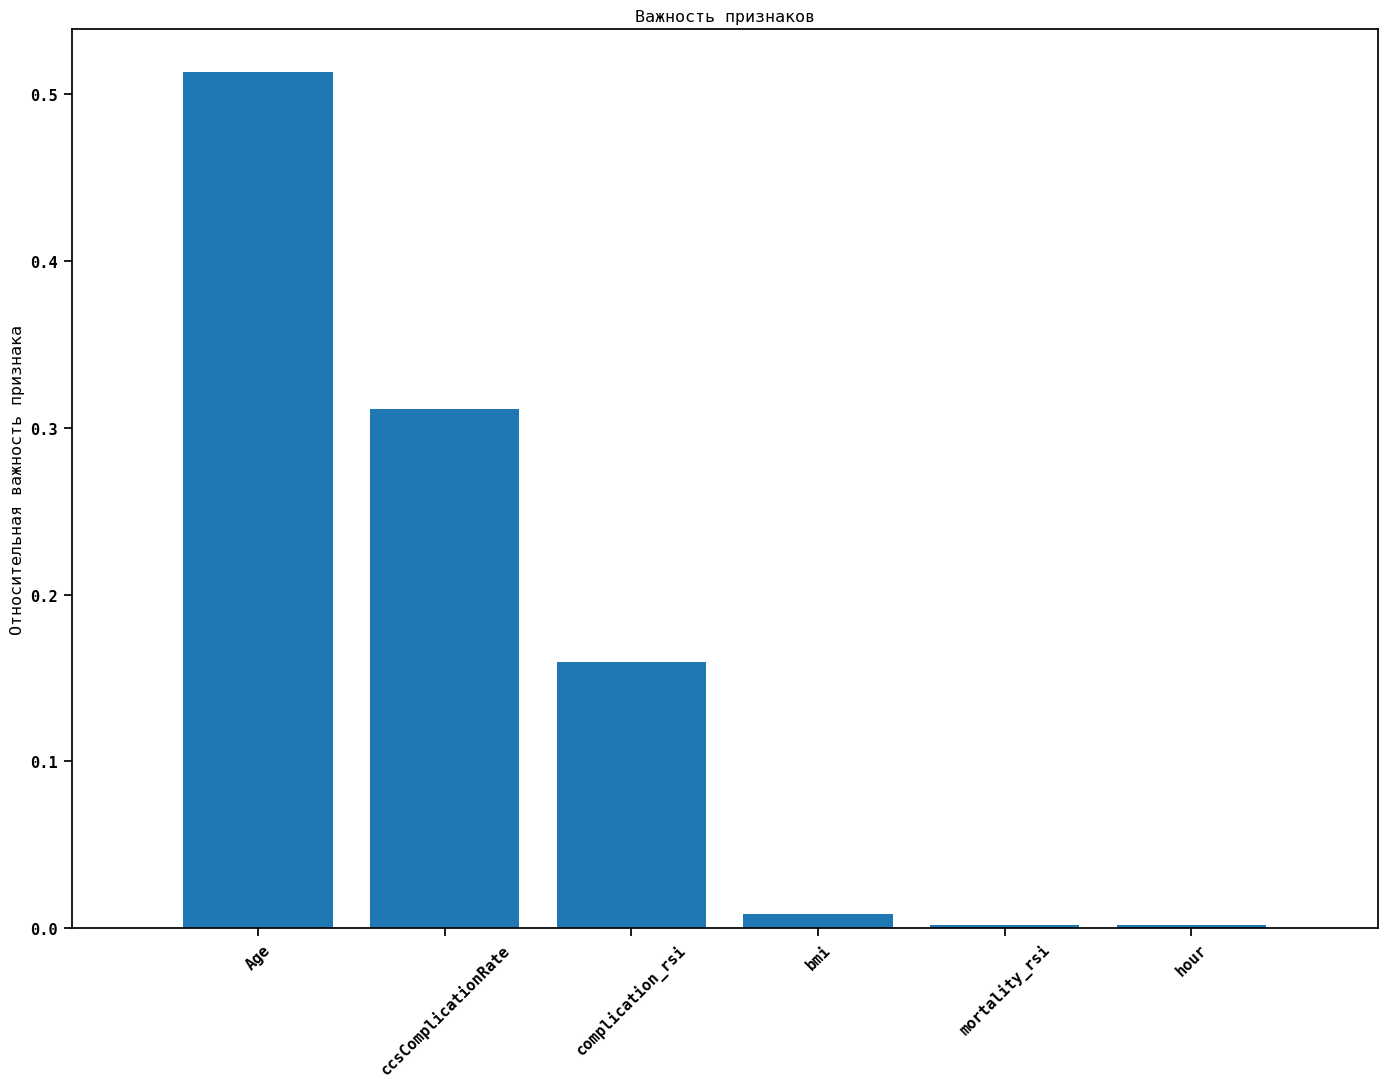

In [ ]:
preprocessor_forplot = ColumnTransformer(
    [
        ('category', OneHotEncoder(drop='first'), category_cols+binary_cols),
        ('numeric', 'passthrough', continuous_cols),
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value',
                                   unknown_value=np.nan), ordinal_cols),
    ],
    sparse_threshold=0,
    remainder='drop',
    verbose_feature_names_out=False,
)
feat_labels = preprocessor_forplot.fit(X_train).get_feature_names_out()
importances = search_model['models'].feature_importances_
indices = np.argsort(importances)[::-1]
importances_notnull = []
important_labels = []

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))
    if importances[indices[f]]>0.001:
        importances_notnull.append(importances[indices[f]])
        important_labels.append(feat_labels[indices[f]])

plt.title('Важность признаков')
plt.bar(range(len(importances_notnull)), 
        importances_notnull,
        align='center')

plt.xticks(range(len(importances_notnull)), 
           important_labels, rotation=45)
plt.xlim([-1, len(importances_notnull)])
plt.ylabel('Относительная важность признака')
plt.tight_layout()
plt.show()

На графике показаны наиболее важные признаки для модели случайного леса. Всего лишь три признака суммарно дают показатель относительной важности более 0,9.

### Ансамбль классификаторов

In [396]:
# выведем лучшую модель SVC
search_df[search_df['param_models']==search_df['param_models'].unique()[0]].sort_values('rank_test_score').head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__C,param_models__kernel,param_preprocessor__numeric,param_models__degree,param_models__max_depth,param_models__max_features,param_models__min_samples_leaf,param_models__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
6,2.37995,0.052162,1.252413,0.024528,SVC(random_state=42),10.0,rbf,StandardScaler(),NaN,NaN,NaN,NaN,NaN,"{'models': SVC(random_state=42), 'models__C': ...",0.46893,0.433378,0.458839,0.453716,0.014959,36


In [403]:
# определим лучшие модели отдельно для реализации ансамбля
best_forest = RandomForestClassifier(random_state=RANDOM_STATE,
                                    max_depth=5,
                                    max_features=None,
                                    min_samples_leaf=3,
                                    n_estimators=225)
best_SVC = SVC(random_state=RANDOM_STATE,
               C=10,
               kernel='rbf',
               probability=True)
best_lr = LogisticRegression(C=25,
                             penalty='l2',
                             solver='saga')

In [404]:
# определим три пайплайна
preprocessor_for_forest = ColumnTransformer(
    [
        ('category', OneHotEncoder(drop='first'), category_cols+binary_cols),
        ('numeric', 'passthrough', continuous_cols),
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value',
                                   unknown_value=np.nan), ordinal_cols),
    ],
    sparse_threshold=0,
    remainder='drop',
    verbose_feature_names_out=False,
)

pipeline_forest = Pipeline([
    ('preprocessor', preprocessor_for_forest),
    ('drop_nan', SimpleImputer(strategy='most_frequent')),
    ('models', best_forest),
])

preprocessor_for_svc_and_lr = ColumnTransformer(
    [
        ('category', OneHotEncoder(drop='first'), category_cols+binary_cols),
        ('numeric', StandardScaler(), continuous_cols),
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value',
                                   unknown_value=np.nan), ordinal_cols),
    ],
    sparse_threshold=0,
    remainder='drop',
    verbose_feature_names_out=False,
)

pipeline_svc = Pipeline([
    ('preprocessor', preprocessor_for_svc_and_lr),
    ('drop_nan', SimpleImputer(strategy='most_frequent')),
    ('models', best_SVC),
])

pipeline_lr = Pipeline([
    ('preprocessor', preprocessor_for_svc_and_lr),
    ('drop_nan', SimpleImputer(strategy='most_frequent')),
    ('models', best_lr),
])

In [418]:
# обучим модели
pipelines = [pipeline_forest, pipeline_svc, pipeline_lr]
[pipe.fit(X_train, y_train) for pipe in pipelines]

[Pipeline(steps=[('preprocessor',
                  ColumnTransformer(sparse_threshold=0,
                                    transformers=[('category',
                                                   OneHotEncoder(drop='first'),
                                                   ['ahrq_ccs', 'month', 'race',
                                                    'moonphase',
                                                    'baseline_cancer',
                                                    'baseline_cvd',
                                                    'baseline_dementia',
                                                    'baseline_diabetes',
                                                    'baseline_digestive',
                                                    'baseline_osteoart',
                                                    'baseline_psych',
                                                    'baseline_pulmonary',
                                             

In [432]:
predictions = pd.DataFrame()
for i, pipe in enumerate(pipelines):
    predictions.loc[:, i] = pipe.predict(X_test)
    predictions.loc[:, i+3] = pipe.predict_proba(X_test)[:, 1]
predictions.columns = ['forest', 'forest_proba', 'svc',
                       'svc_proba', 'lr', 'lr_proba']

In [450]:
# мажоритарное голосование
predictions['majority_vote'] = predictions[['forest', 'svc', 'lr']].mode(axis=1)
# взвешенное голосование по вероятностям
predictions['vote_proba'] = predictions[['forest_proba', 'svc_proba', 'lr_proba']].\
    mean(axis=1).apply(lambda x: 1 if x>=0.5 else 0)

In [463]:
# метрики мажоритарного голосования
majority_vote = predictions['majority_vote']
precision = metrics.precision_score(y_test, majority_vote)
recall = metrics.recall_score(y_test, majority_vote)
f1_score = metrics.f1_score(y_test, majority_vote)
mcc = metrics.matthews_corrcoef(y_test, majority_vote)
error = 1 - metrics.accuracy_score(y_test, majority_vote)
print(f'Значения основных метрик на тестовых данных:\n \
Ошибка прогнозирования {error:.3f}\n \
Точность {precision:.3f}\n \
Полнота {recall:.3f}\n \
F1_score {f1_score:.3f}\n \
Коэффициент корреляции {mcc:.3f}')

Значения основных метрик на тестовых данных:
 Ошибка прогнозирования 0.184
 Точность 0.710
 Полнота 0.353
 F1_score 0.472
 Коэффициент корреляции 0.408


In [475]:
# метрики голосования c учётом вероятностей
vote_proba = predictions['vote_proba']
precision = metrics.precision_score(y_test, vote_proba)
recall = metrics.recall_score(y_test, vote_proba)
f1_score = metrics.f1_score(y_test, vote_proba)
mcc = metrics.matthews_corrcoef(y_test, vote_proba)
error = 1 - metrics.accuracy_score(y_test, vote_proba)
print(f'Значения основных метрик на тестовых данных:\n \
Ошибка прогнозирования {error:.3f}\n \
Точность {precision:.3f}\n \
Полнота {recall:.3f}\n \
F1_score {f1_score:.3f}\n \
Коэффициент корреляции {mcc:.3f}')

Значения основных метрик на тестовых данных:
 Ошибка прогнозирования 0.172
 Точность 0.801
 Полнота 0.349
 F1_score 0.486
 Коэффициент корреляции 0.452


Оба реализованных голосования ансамбля работают хуже, чем случайный лес.

Введение новой модели, обучающейся на предсказаниях моделей из ансамбля

In [470]:
X_train_reduce, X_val, y_train_reduce, y_val = train_test_split(
    X_train,
    y_train,
    test_size = TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_train
    )

pipeline_forest_reduce = Pipeline([
    ('preprocessor', preprocessor_for_forest),
    ('drop_nan', SimpleImputer(strategy='most_frequent')),
    ('models', RandomForestClassifier(random_state=RANDOM_STATE,
                                      max_depth=5,
                                      max_features=None,
                                      min_samples_leaf=3,
                                      n_estimators=225)),
])

pipeline_svc_reduce = Pipeline([
    ('preprocessor', preprocessor_for_svc_and_lr),
    ('drop_nan', SimpleImputer(strategy='most_frequent')),
    ('models', SVC(random_state=RANDOM_STATE,
                    C=10,
                    kernel='rbf',
                    probability=True)),
])

pipeline_lr_reduce = Pipeline([
    ('preprocessor', preprocessor_for_svc_and_lr),
    ('drop_nan', SimpleImputer(strategy='most_frequent')),
    ('models', LogisticRegression(C=25,
                                    penalty='l2',
                                    solver='saga')),
])

pipelines_reduce = [pipeline_forest_reduce, pipeline_svc_reduce, pipeline_lr_reduce]
[pipe.fit(X_train_reduce, y_train_reduce) for pipe in pipelines_reduce]

predictions_val = pd.DataFrame()
for i, pipe in enumerate(pipelines_reduce):
    predictions_val.loc[:, i] = pipe.predict(X_val)
    predictions_val.loc[:, i+3] = pipe.predict_proba(X_val)[:, 1]
predictions_val.columns = ['forest', 'forest_proba', 'svc',
                       'svc_proba', 'lr', 'lr_proba']

In [471]:
predictions_test = pd.DataFrame()
for i, pipe in enumerate(pipelines_reduce):
    predictions_test.loc[:, i] = pipe.predict(X_test)
    predictions_test.loc[:, i+3] = pipe.predict_proba(X_test)[:, 1]
predictions_test.columns = ['forest', 'forest_proba', 'svc',
                       'svc_proba', 'lr', 'lr_proba']

In [488]:
clf_vote = LogisticRegression()
clf_vote.fit(predictions_val[['forest', 'forest_proba', 'svc',
                       'svc_proba', 'lr', 'lr_proba']], y_val)
predictions_lr_vote = clf_vote.predict(predictions_test[['forest', 'forest_proba', 'svc',
                       'svc_proba', 'lr', 'lr_proba']])

In [489]:
# метрики логистической регресси, обученной на предсказаниях моделей из ансамбля
precision = metrics.precision_score(y_test, predictions_lr_vote)
recall = metrics.recall_score(y_test, predictions_lr_vote)
f1_score = metrics.f1_score(y_test, predictions_lr_vote)
mcc = metrics.matthews_corrcoef(y_test, predictions_lr_vote)
error = 1 - metrics.accuracy_score(y_test, predictions_lr_vote)
print(f'Значения основных метрик на тестовых данных:\n \
Ошибка прогнозирования {error:.3f}\n \
Точность {precision:.3f}\n \
Полнота {recall:.3f}\n \
F1_score {f1_score:.3f}\n \
Коэффициент корреляции {mcc:.3f}')

Значения основных метрик на тестовых данных:
 Ошибка прогнозирования 0.147
 Точность 0.816
 Полнота 0.475
 F1_score 0.601
 Коэффициент корреляции 0.546


Модель логистической регрессии показывает наилучшие метрики

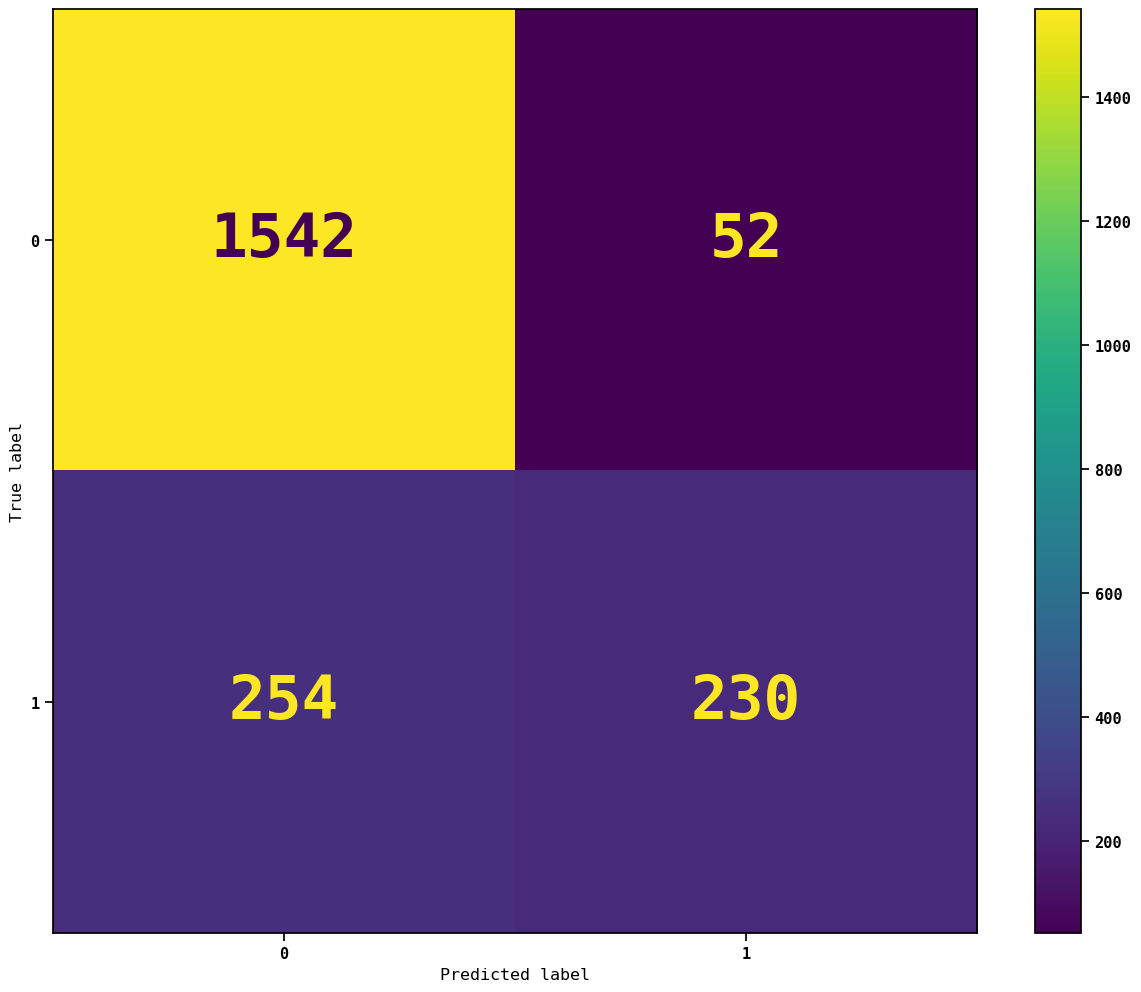

In [490]:
confmat_lr_vote = metrics.confusion_matrix(y_test, predictions_lr_vote)
confmat_lr_vote_display = metrics.ConfusionMatrixDisplay(confmat_lr_vote)
confmat_lr_vote_display.plot()
plt.show()

Матрица ошибок соответственно показывает улучшение предсказаний

 1) forest_proba                   6.275398
 2) lr_proba                       1.808080
 3) svc_proba                      1.285233
 4) svc                            -0.052358
 5) forest                         -0.366436
 6) lr                             -0.950799


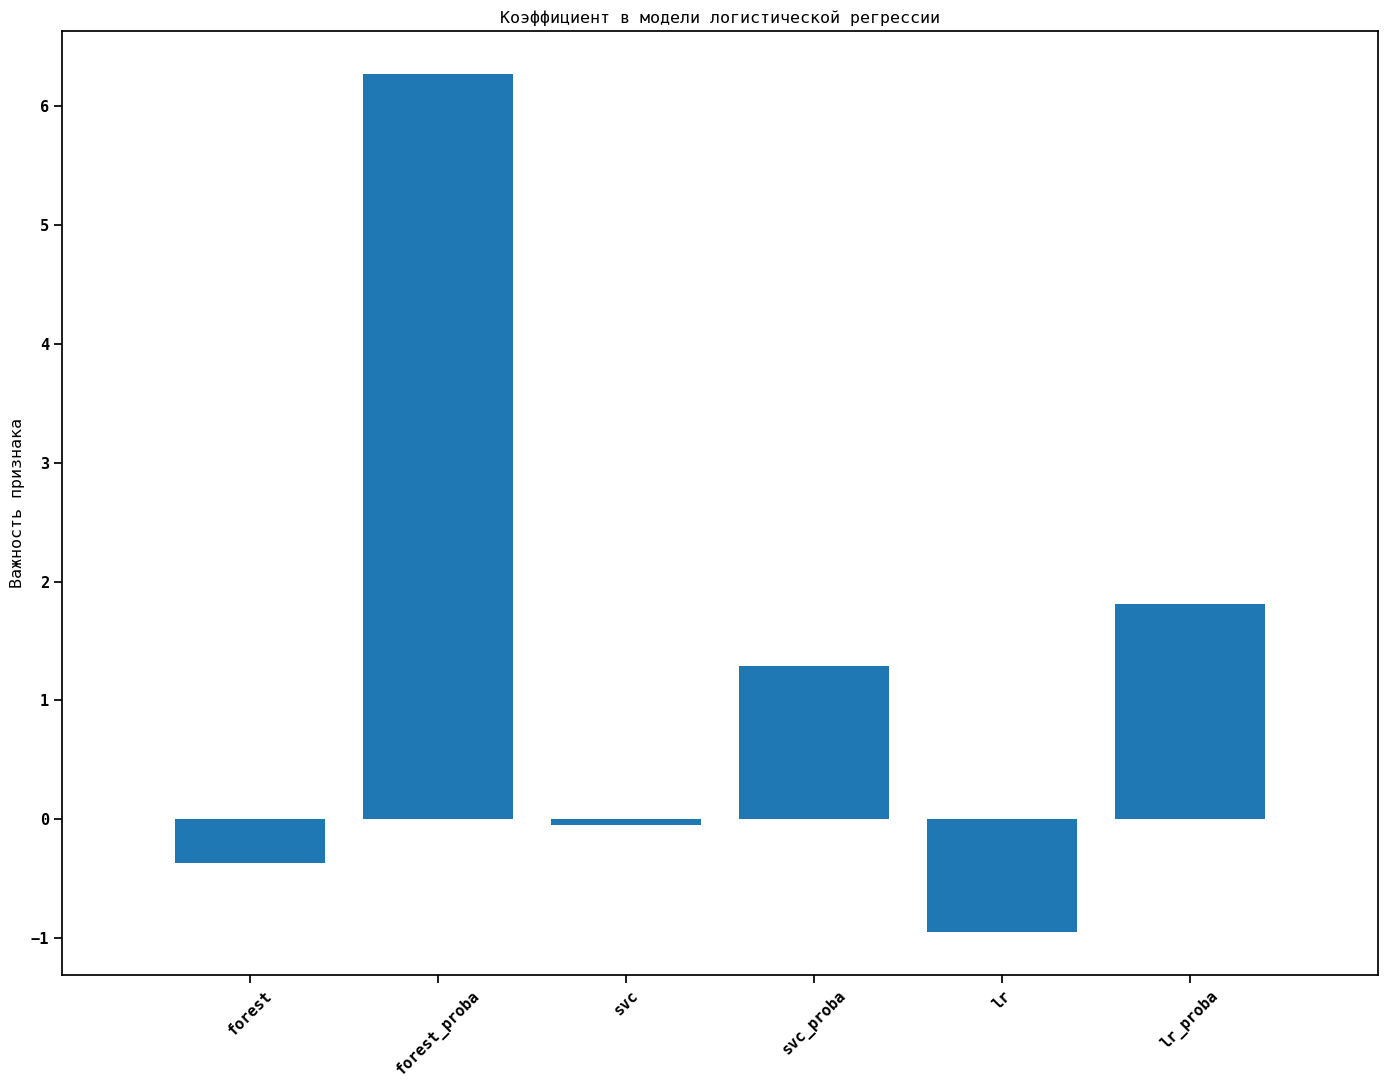

In [524]:
labels = predictions_test.columns
lr_coefs = clf_vote.coef_[0]
indices_lr = np.argsort(lr_coefs)[::-1]

for f in range(predictions_test.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            labels[indices_lr[f]], 
                            lr_coefs[indices_lr[f]]))

plt.title('Коэффициент в модели логистической регрессии')
plt.bar(range(len(lr_coefs)), 
        lr_coefs,
        align='center')

plt.xticks(range(len(lr_coefs)), 
           labels, rotation=45)
plt.xlim([-1, len(lr_coefs)])
plt.ylabel('Важность признака')
plt.tight_layout()
plt.show()

Логично, что вероятности случайного леса (наиболее сильной модели) являются наиболее существенными для логистической регрессии ансамбля.

## Решение задачи регрессии

In [336]:
y_regr = df['Age']
df_regr = df.drop('Age', axis=1)

In [337]:
X_train_regr, X_test_regr, y_train_regr, y_test_regr = train_test_split(
    df_regr,
    y_regr,
    test_size = TEST_SIZE,
    random_state=RANDOM_STATE
    )

In [338]:
print(f'Размер тренировочной выборки: {X_train_regr.shape}\n \
Размер тестовой выборки {X_test_regr.shape}')

Размер тренировочной выборки: (11772, 24)
 Размер тестовой выборки (2078, 24)


In [339]:
continuous_cols_regr = ['bmi', 'ccsComplicationRate', 'ccsMort30Rate', 
                'complication_rsi', 'hour', 'mortality_rsi']
binary_cols_regr = ['baseline_cancer', 'baseline_cvd', 'baseline_dementia', 
                'baseline_diabetes', 'baseline_digestive', 'baseline_osteoart', 
                'baseline_psych', 'baseline_pulmonary', 'gender', 'mort30', 'complication']

In [ ]:
encoders_num = [
    StandardScaler(),
    RobustScaler(),
    MinMaxScaler(),
]

preprocessor = ColumnTransformer(
    [
        ('category', OneHotEncoder(drop='first'), category_cols+binary_cols_regr),
        ('numeric', StandardScaler(), continuous_cols_regr),
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value',
                                   unknown_value=np.nan), ordinal_cols),
    ],
    sparse_threshold=0,
    remainder='drop',
    verbose_feature_names_out=False,
)

param_space = [
    {
        'models': [SVR(kernel='poly')],
        'models__C': np.logspace(-1, 3, 5, base=10),
        'models__degree': np.arange(1, 4),
        'preprocessor__numeric': encoders_num,
    },
    {
        'models': [SGDRegressor(random_state=RANDOM_STATE)],
        'models__penalty': ['l2', 'l1', 'elacticnet'],
        'models__alpha': np.logspace(-1, 3, 5, base=10),
        'models__l1_ratio': np.logspace(-1, 3, 5, base=10),
        'preprocessor__numeric': encoders_num,
    },
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': np.arange(25, 250, step=50),
        'models__max_features': ['sqrt', 'log2', None],
        'models__max_depth': np.arange(2, 6),
        'models__min_samples_leaf': np.arange(2, 4),
        'preprocessor__numeric': ['passthrough'],
    },
]

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('drop_nan', SimpleImputer(strategy='most_frequent')),
    ('models', SVR(kernel='poly')),
])

search_regressor = GridSearchCV(
    pipeline,
    param_grid=param_space,
    cv=3,
    scoring='neg_mean_squared_error',
)
search_regressor.fit(X_train_regr, y_train_regr)

In [363]:
search_regressor_df = pd.DataFrame(search_regressor.cv_results_)
search_regressor_df.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__C,param_models__degree,param_preprocessor__numeric,param_models__alpha,param_models__l1_ratio,param_models__penalty,param_models__max_depth,param_models__max_features,param_models__min_samples_leaf,param_models__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
23,2.916446,0.197956,0.774989,0.082840,SVR(kernel='poly'),10.0,2.0,MinMaxScaler(),NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'models': SVR(kernel='poly'), 'models__C': 10...",-96.683305,-97.890025,-95.978951,-96.850760,0.789127,1
22,2.654505,0.052483,0.732442,0.009175,SVR(kernel='poly'),10.0,2.0,RobustScaler(),NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'models': SVR(kernel='poly'), 'models__C': 10...",-97.565110,-97.435595,-96.773085,-97.257930,0.346891,2
21,2.950170,0.169221,0.774625,0.034853,SVR(kernel='poly'),10.0,2.0,StandardScaler(),NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'models': SVR(kernel='poly'), 'models__C': 10...",-97.686119,-97.123212,-97.584199,-97.464510,0.244895,3
383,2.553776,0.007839,0.060046,0.008229,RandomForestRegressor(random_state=42),NaN,NaN,passthrough,NaN,NaN,NaN,5.0,None,2.0,175.0,{'models': RandomForestRegressor(random_state=...,-97.123586,-99.593741,-96.941992,-97.886440,1.209519,4
384,3.255596,0.003211,0.069815,0.004290,RandomForestRegressor(random_state=42),NaN,NaN,passthrough,NaN,NaN,NaN,5.0,None,2.0,225.0,{'models': RandomForestRegressor(random_state=...,-97.159998,-99.544197,-96.974707,-97.892967,1.170044,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,0.068473,0.001192,0.000000,0.000000,SGDRegressor(random_state=42),NaN,NaN,RobustScaler(),1000.0,100.0,l2,NaN,NaN,NaN,NaN,"{'models': SGDRegressor(random_state=42), 'mod...",NaN,NaN,NaN,NaN,NaN,226
254,0.056428,0.003898,0.000000,0.000000,SGDRegressor(random_state=42),NaN,NaN,MinMaxScaler(),1000.0,100.0,l2,NaN,NaN,NaN,NaN,"{'models': SGDRegressor(random_state=42), 'mod...",NaN,NaN,NaN,NaN,NaN,226
255,0.064732,0.003511,0.000000,0.000000,SGDRegressor(random_state=42),NaN,NaN,StandardScaler(),1000.0,100.0,l1,NaN,NaN,NaN,NaN,"{'models': SGDRegressor(random_state=42), 'mod...",NaN,NaN,NaN,NaN,NaN,226
246,0.062732,0.002129,0.000000,0.000000,SGDRegressor(random_state=42),NaN,NaN,StandardScaler(),1000.0,10.0,l1,NaN,NaN,NaN,NaN,"{'models': SGDRegressor(random_state=42), 'mod...",NaN,NaN,NaN,NaN,NaN,226


In [370]:
search_regressor_df.to_excel('search_regressor.xlsx')

In [365]:
best_regressor = search_regressor.best_estimator_

In [366]:
y_pred_regressor = best_regressor.predict(X_test_regr)

In [367]:
mae = metrics.mean_absolute_error(y_test_regr, y_pred_regressor)
rmse = metrics.root_mean_squared_error(y_test_regr, y_pred_regressor)
meae = metrics.median_absolute_error(y_test_regr, y_pred_regressor)
r2_score = metrics.r2_score(y_test_regr, y_pred_regressor)
print(f'Значения основных метрик на тестовых данных:\n \
Корень из средней квадратичной ошибки {rmse:.3f}\n \
Средняя абсолютная ошибка {mae:.3f}\n \
Медианная абсолютная ошибка {meae:.3f}\n \
Коэффициент детерминации (r2-score) {r2_score:.3f}')

Значения основных метрик на тестовых данных:
 Корень из средней квадратичной ошибки 9.577
 Средняя абсолютная ошибка 6.775
 Медианная абсолютная ошибка 5.073
 Коэффициент детерминации (r2-score) 0.711
